<a name="index"></a>
# 1. Index

Here is the modified list with the index starting at 1 instead of 0:

1. [Index](#index)<br>
2. [Einleitung](#2-einleitung)<br>
    2.1 [Motivation](#21-motivation)<br>
    2.2 [Warum PyTorch?](#22-warum-pytorch)<br>
    2.3 [Vorgehensweise](#23-vorgehensweise)<br>
3. [Voraussetzungen & Einrichtung](#3-voraussetzungen-einrichtung)<br>
    3.1 [Einrichtungsanleitung](#31-einrichtungsanleitung)<br>
    3.2 [Imports](#32-imports)<br>
    3.3 [Types & Pfade](#33-types-pfade)<br>
    3.4 [Print-formatierer](#34-print-formatierer)<br>
4. [Zentrale Konfiguration](#4-zentrale-konfiguration)<br>
    4.1 [Modus](#41-modus)<br>
    4.2 [Laden des State Dictionary](#42-laden-des-state-dictionary)<br>
    4.3 [Hyperparameter-Grid](#43-hyperparameter-grid)<br>
5. [Datenvorverarbeitung](#5-datenvorverarbeitung)<br>
    5.1 [Laden](#51-laden)<br>
    5.2 [Analyse](#52-analyse)<br>
    5.3 [Transformation](#53-transformation)<br>
    5.4 [Untersuchung](#54-untersuchung)<br>
6. [Modellarchitektur](#6-modellarchitektur)<br>
7. [Trainingsschleife](#7-trainingsschleife)<br>
    7.1 [Logger](#71-logger)<br>
    7.2 [Trainieren & Validieren](#72-trainieren-validieren)<br>
8. [Protokollierung & Plotten](#8-protokollierung-plotten)<br>
    8.1 [Protokollierung](#81-protokollierung)<br>
    8.2 [Plotten](#82-plotten)<br>
9. [Modellgenerierung](#9-modellgenerierung)<br>
    9.1 [Speichern & Laden](#91-speichern-laden)<br>
    9.2 [Programmmodi](#92-programmmodi)<br>
    9.3 [Speicherverwaltung](#93-speicherverwaltung)<br>
    9.4 [Ausführung](#94-ausführung)<br>
10. [Kommentar](#kommentar)<br>
11. [Literaturverzeichnis](#literaturverzeichnis)<br>

<a name="2-einleitung"></a>
# 2. Einleitung

Dieses Jupyter-notebook löst das Problem der Vorhersage der Orientierung eines Rubik's Cubes anhand von Bildern. Der Datensatz enthält 5000 Trainingsbilder und 5001 Testbilder. Ziel ist es, den `xRot`-Wert vorherzusagen, der die Orientierung in Grad darstellt. Er wurde erstmals auf "AI Crowd" im Rahmen der sogenannten "KIIT AI (Mini)Blitz Challenge" [1] veröffentlicht. Die ursprüngliche Challenge ist auf [aicrowd](https://www.aicrowd.com/challenges/kiit-ai-mini-blitz/problems/orient-rubiks-cube) zu finden. Dann erschien sie erneut auf [Kaggle](https://www.kaggle.com/datasets/bjoernjostein/rubix-cube) worauf ich gestoßen bin, nachdem ich nach Stichwörtern wie "Orientierung" und "Computer Vision" suchte.

<a name="21-motivation"></a>
## 2.1 Motivation

Die Orientierung von Objekten ist eine große Herausforderung und ein Ziel in vielen Bereichen: von Anwendungen im medizinischen Bereich zur Unterstützung von Chirurgen bei Operationen und der Verfolgung ihrer Instrumente [2] bis hin zu den Bereichen Ingenieurwesen und Wissenschaft wie Robotik und autonome Fahrzeuge.

Das Ziel ist es, ein "Kameragyroskop" zu erstellen, das die Position eines Rubik's Würfels ohne die Verwendung eines physischen Gyroskops bestimmen kann. Potenziell könnte dieses Modell erweitert oder als Transfer-Learning-Schicht zur Lösung komplexerer Orientierungsherausforderungen implementiert werden.

<a name="22-warum-pytorch"></a>
## 2.2 Warum PyTorch?

Ich habe PyTorch verwendet, da es näher an Python ist und Low-Level-Coding für hochgradig angepasste Lösungen ermöglicht. Dies hilft, maschinelle Lernkonzepte besser zu verstehen und bietet eine größere architektonische Freiheit.

Anfangs habe ich normale Logging-Methoden durch Printing/Plotting von Ausgaben verwendet, was die grafische Übersicht von TensorFlow's TensorBoard vermissen lässt. Allerdings habe ich im Laufe des Projekts herausgefunden, dass PyTorch TensorBoard implementieren kann, also habe ich es ebenfalls im Projekt genutzt. Dennoch habe ich festgestellt, dass es einige funktionale Einschränkungen bei der Verwendung mit PyTorch gibt, da es ursprünglich dafür entwickelt wurde, mit TensorFlow zusammenzuarbeiten. Probleme wie die Unfähigkeit, den Projektormodus zu nutzen, könnten jedoch auch auf die Einschränkungen meines lokalen Geräts zurückzuführen sein.

<a name="23-vorgehensweise"></a>
## 2.3 Vorgehensweise

Eine höhe Priorität wurde auf die leichte Skalierbarkeit gesetzt damit, zukünftige Experimente zu ermöglichen und sie reproduzierbar zu machen. Daher wurde der Code so abstrakt und generisch wie möglich mit zentraler Steuerung geschrieben.

<a name="3-voraussetzungen-einrichtung"></a>
# 3. Voraussetzungen & Einrichtung


<a name="31-einrichtungsanleitung"></a>
## 3.1 Einrichtungsanleitung


Bitte laden Sie zunächst diesen Datensatz von [Kaggle](https://www.kaggle.com/datasets/bjoernjostein/rubix-cube) über den Download-Button oben rechts herunter. Nach dem Herunterladen entpacken Sie den Ordner namens `archive` und benennen ihn in `source` um. Verschieben Sie den Ordner `source` in dasselbe Verzeichnis wie diese Datei.

WICHTIG: Bitte beachten Sie, dass die Abhängigkeiten nicht gut mit Conda funktionieren. Das könnte ein Problem mit Paketkonflikten zwischen tensorboard und pytorch-Bibliotheken sein, daher musste ich `venv` und `pip` verwenden, um die notwendigen Abhängigkeiten zu installieren.

Für den Zugriff auf Tensorboard beim Training des Modells verwenden Sie diesen Befehl: `tensorboard --logdir=runs`, `runs` wird standardmäßig automatisch generiert. Das Ändern des Namens dieses Ordners erfordert Änderungen an den Einstellungen von Tensorboard, daher wird empfohlen, diesen Namen beizubehalten.

Eine Liste der Projektabhängigkeiten finden Sie in der Datei `requirements.txt`, die mit `pip freeze > requirements.txt` erstellt wurde.

<a name="32-imports"></a>
## 3.2 Imports


In [1]:
# Standard libraries
import os
import random
from datetime import datetime, timedelta
import time
import gc
import itertools
import csv

# Scientific libraries
import numpy as np
import pandas as pd
from PIL import Image

# Machine learning and PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

# Metrics and evaluation
from sklearn.model_selection import train_test_split
from torchmetrics import MeanAbsoluteError, MeanSquaredError, R2Score
from tensorboard.backend.event_processing import event_accumulator
from tensorboardX import SummaryWriter

# Visualization
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from tabulate import tabulate

# Typing
from typing import List, Tuple

<a name="33-types-pfade"></a>
## 3.3 Types & Pfade


Der `Hparams`-Typ wird für Wörterbücher verwendet, die Hyperparameter enthalten, während der `ImageSize`-Typ für Tupel verwendet wird, die die Abmessungen unserer Eingabebilder darstellen.

In [2]:
Hparams = dict[str, list]
ImageSize = Tuple[int, int, int]

Hier wird das Gerät definiert, um sicherzustellen, dass der Code geräteunabhängig ist und je nach Verfügbarkeit entweder auf einer CPU oder GPU ausgeführt werden kann. Zusätzlich werden feste Pfade für die Trainingsbilder und Labelfiles festgelegt.

In [3]:
# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# # Define paths
train_dir_path : str = 'source/training/training/images'
labels_file_path : str = 'source/training/training/labels.csv'

Using device: cpu


<a name="34-print-formatierer"></a>
## 3.4 Print-formatierer


Um die Lesbarkeit der ausgegebenen Werte zu verbessern, wird eine Wrapper-Funktion mit der Bibliothek `tabulate` erstellt. Diese Funktion formatiert die Ausgabe als ordentlich organisierte Tabelle, wodurch die Ergebnisse leichter zu interpretieren sind.

Diese Wrapper-Funktion, `pretty_print`, nimmt eine Liste von Listen als Eingabe, wobei jede innere Liste eine Datenzeile darstellt. Die Funktion formatiert die erste Spalte und die Überschriften fett, um die Lesbarkeit zu verbessern. Die Bibliothek `tabulate` wird dann verwendet, um die Daten in einem gut organisierten Rasterformat auszugeben.

In [4]:

# https://stackoverflow.com/questions/8924173/how-can-i-print-bold-text-in-python

# ANSI escape codes for bold
bold = "\033[1m"
reset = "\033[0m"


# https://stackoverflow.com/questions/9535954/printing-lists-as-tabular-data

# Function to print the table with bold formatting for first row and first column

def pretty_print(table_data: List[List[str]]) -> None:
    """
    Prints a formatted table with bold headers and values.

    Args:
        table_data (List[List[str]]): A 2D list of strings representing the table data.

    Returns:
        None
    """
    # Apply bold formatting to the first column and header row
    headers = [f"{bold}Description{reset}", f"{bold}Value{reset}"]
    formatted_table = [[f"{bold}{cell}{reset}" if col == 0 else cell for col, cell in enumerate(row)] for row in table_data]

    # Insert headers as the first row in the table data
    formatted_table.insert(0, headers)

    # Print the table with tabulate
    print(tabulate(formatted_table, headers="firstrow", tablefmt="grid", maxcolwidths=[None, 80]))


<a name="4-zentrale-konfiguration"></a>
# 4. Zentrale Konfiguration


Diese Struktur bietet einen zentralen Kontrollpunkt für die gesamte Datenverarbeitung, Modellkonfiguration und Betriebsmodi.

Es ist eine Art lokale API. Wenn diese in einen Webservice, ein Gerät oder eine GUI integriert wird, könnte diese Zentralisierung für die Skalierbarkeit wertvoll sein, da sie als Blueprint für die eigentliche API dienen könnte. Sie kann sogar erweitert werden, um Modellarchitekturen, Loss functions und Optimizers zu wechseln.

Durch diese zentrale Steuerung können Sie verschiedene Aspekte des Projekts einfach verwalten und ändern, ohne umfangreiche Anpassungen vornehmen zu müssen.

<a name="41-modus"></a>
## 4.1 Modus


Um das Dokument in den Trainings- oder Bewertungsmodus zu versetzen, definieren wir eine boolesche Variable `eval_mode`. Diese Variable steuert, ob der Code im Trainingsmodus oder im Bewertungsmodus ausgeführt wird.

Wenn `eval_mode` auf `False` gesetzt ist, wird der Code im Trainingsmodus ausgeführt, sodass das Modell auf dem Datensatz trainiert werden kann. Wenn `eval_mode` auf `True` gesetzt ist, wird der Code in den Bewertungsmodus wechseln, wodurch das Modell anhand der Testdaten bewertet werden kann. Diese Variable bietet eine bequeme Möglichkeit, zwischen diesen beiden Modi je nach Entwicklungs- oder Testphase zu wechseln.

In [5]:
# set the document in train mode or evaluation mode
eval_mode : bool = True

<a name="42-laden-des-state-dictionary"></a>
## 4.2 Laden des State Dictionary


Wenn das Programm in den Bewertungsmodus versetzt wird, bedeutet dies, dass wir bereits ein Modell trainiert haben. 

Daher definieren wir den Pfad zum vorhandenen Modell, das geladen werden soll.

In [6]:
# set the path to the dataset using a raw string to avoid escape characters
load_state_dict_path : str = r'models/EPOCHS_400_BATCH_SIZES_32_IMG_PIXEL_VALS_128_LEARN_RATES_0.001_ACTIVATIONS_relu_T2024-07-24_08-33-45.pth'

# check if the file exists
if not os.path.isfile(load_state_dict_path) and eval_mode:
    raise FileNotFoundError(f"The file {load_state_dict_path} does not exist.")


<a name="43-hyperparameter-grid"></a>
## 4.3 Hyperparameter Grid


Dieser Teil der Konfiguration ist die wichtigste Komponente und dient als zentrales Hub, das alle Operationen an einem Ort dynamisch steuert. Anstatt bei jedem Experiment Werte überall aktualisieren zu müssen, ermöglicht dieser Ansatz eine zentrale Verwaltung im gesamten Programm, was iterative Modellverbesserungen einfacher und skalierbarer macht.

Es bietet ein Hyperparameter-Raster zur Modelloptimierung, beginnend mit einem Satz von Werten, die ausprobiert werden sollen. Das `Hparams_grid`-Wörterbuch enthält Listen von Werten für jeden Hyperparameter, was einfache Experimente und Optimierungen an einem Ort ermöglicht.

Beispielwerte für ein Hyperparameter-Raster zur Modell-Hyperparameter-Optimierung:

```
Hparams_grid : Hparams = {
    "epochs": [50],
    "batch_sizes": [32],
    "img_pixel_vals": [128, 256, 512],
    "learn_rates": [0.001, 0.005],
    "activations": ['relu', 'leaky_relu', 'elu','prelu', 'sigmoid']
}
```

In [7]:
Hparams_grid : Hparams = {
    "epochs": [400],
    "batch_sizes": [32],
    "img_pixel_vals": [128], # when loading a state dict make sure to use the same value here
    "learn_rates": [0.001],
    "activations": ['relu'],
}

<a name="5-datenvorverarbeitung"></a>
# 5. Datenvorverarbeitung


<a name="51-laden"></a>
## 5.1 Laden


Die Labels aus der CSV-Datei, die durch `labels_file_path` angegeben wird, werden geladen.

In [8]:
labels = pd.read_csv(labels_file_path)
labels

,filename,xRot
0,000000.jpg,336.838887
1,000001.jpg,148.484378
2,000002.jpg,244.821661
3,000003.jpg,222.700630
4,000004.jpg,172.358121
...,...,...
4995,004995.jpg,90.167663
4996,004996.jpg,29.196271
4997,004997.jpg,99.502175
4998,004998.jpg,345.309582


Da unser Datensatz keine eingebaute sklearn- oder PyTorch-Datenklasse mit einer Standardklasse ist, müssen wir eine benutzerdefinierte Klasse selbst definieren, um ihn für PyTorch lesbar und trainierbar zu machen.

Diese Klasse `RubikCustomDataset` erweitert die `Dataset`-Klasse von PyTorch, um einen benutzerdefinierten Datensatz für Rubik's Cube-Bilder zu erstellen.

Sie bietet eine angepasste Möglichkeit, Bilder und Labels aus einem Verzeichnis und einer CSV-Datei zu laden. Dieser benutzerdefinierte Datensatz kann dann mit den Datenladefunktionen von PyTorch verwendet werden, um das Modelltraining und die Bewertung zu erleichtern. Die Vererbung von `Dataset` ermöglicht eine nahtlose Integration in das Datenverwaltungssystem von PyTorch.

In [9]:
class RubikCustomDataset(Dataset):
    def __init__(self, img_dir_path : str, labels_file_path : str, transform=None):
        """
        Initializes a custom dataset for Rubik's Cube images.

        Args:
            img_dir_path (str): The directory path where the images are stored.
            labels_file_path (str): The file path of the CSV file containing the image labels.
            transform (callable, optional): A function/transform to be applied on the images. Default is None.
        """
        self.img_dir_path = img_dir_path
        self.labels = pd.read_csv(labels_file_path)
        self.transform = transform

    # magic methods
    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.labels)

    def __iter__(self):
        """
        Returns an iterator over the dataset.

        Returns:
            iterator: An iterator over the dataset.
        """
        return iter(self.labels)

    def __getitem__(self, idx):
        """
        Retrieves the image and label at the given index.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the image and label.
        """
        img_name_path = os.path.join(self.img_dir_path, self.labels.iloc[idx, 0])
        image = Image.open(img_name_path)
        label = self.labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.float32)
        return image, label


<a name="52-analyse"></a>
## 5.2 Analyse


Hier werden der Mittelwert und die Standardabweichung der Daten analysiert. Der Mittelwert und die Standardabweichung der Bilddimensionen werden berechnet, um eine geeignete Größe für die Größenänderung zu bestimmen.

Eine Funktion `get_image_stats` wird definiert, die den Mittelwert und die Standardabweichung der Breiten und Höhen von Bildern in einem angegebenen Verzeichnis berechnet. Die Funktion durchläuft alle Bilder im angegebenen Verzeichnis, extrahiert ihre Breiten und Höhen und berechnet dann den Mittelwert und die Standardabweichung für beide Dimensionen [3].

Diese Funktion wird mit dem Verzeichnispfad der Trainingsbilder aufgerufen, wodurch der Mittelwert und die Standardabweichung für die Bilddimensionen erhalten werden.

Die Funktion `pretty_print` wird dann verwendet, um diese Statistiken in einem lesbaren Format auszugeben.

Diese Analyse hilft, eine anfängliche geeignete Größe für die Größenänderung der Bilder während der Vorverarbeitung zu bestimmen. Es ist zwar nicht garantiert, dass dies die optimalste Größe ist, aber es ist ein guter Ausgangspunkt und kann mit weiteren Experimenten angepasst werden.

In [10]:
def get_image_stats(directory):
    """
    Calculate the mean and standard deviation of the widths and heights of images in a given directory.

    Parameters:
    directory (str): The path to the directory containing the images.

    Returns:
    tuple: A tuple containing the mean width, standard deviation of width, mean height, and standard deviation of height.
    """
    # Initialize lists to store widths and heights
    widths = []
    heights = []

    # Loop through all images and store their widths and heights
    for img_name_path in os.listdir(directory):
        img_path = os.path.join(directory, img_name_path)
        with Image.open(img_path) as img:
            widths.append(img.width)
            heights.append(img.height)

    # Convert lists to numpy arrays
    widths = np.array(widths)
    heights = np.array(heights)

    # Calculate mean and standard deviation
    mean_width = np.mean(widths)
    std_width = np.std(widths)
    mean_height = np.mean(heights)
    std_height = np.std(heights)

    return mean_width, std_width, mean_height, std_height

# Call the function with the desired directory and get each value
mean_width, std_width, mean_height, std_height = get_image_stats(train_dir_path)

pretty_print([
    ["Mean width", mean_width],
    ["Std width", std_width],
    ["Mean height", mean_height],
    ["Std height", std_height]
])


+---------------+---------+
| Description   |   Value |
+===============+=========+
| Mean width    |     512 |
+---------------+---------+
| Std width     |       0 |
+---------------+---------+
| Mean height   |     512 |
+---------------+---------+
| Std height    |       0 |
+---------------+---------+


Um die Verteilung zu überprüfen und festzustellen, ob die Daten ausgeglichen sind, kann ein Histogramm der xRot-Werte aus den Labels erstellt werden.

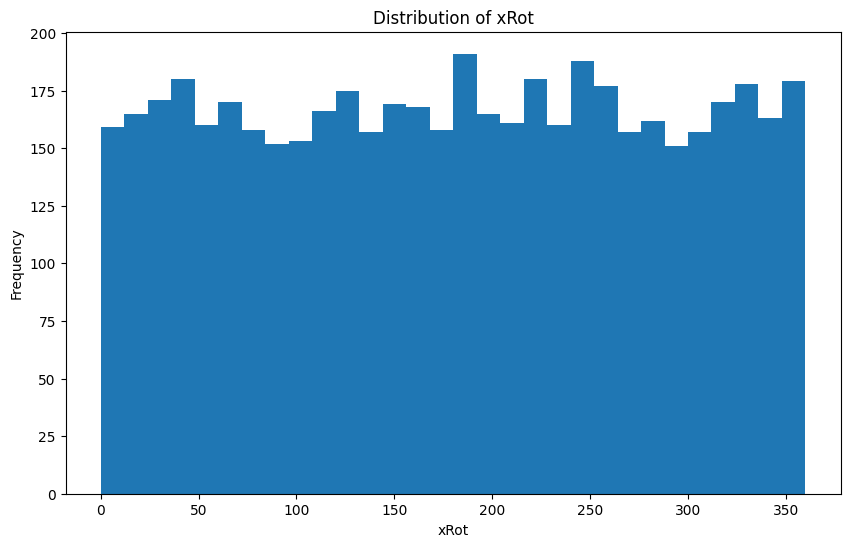

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(labels['xRot'], bins=30)
plt.xlabel('xRot')
plt.ylabel('Frequency')
plt.title('Distribution of xRot')
plt.show()

Aus der Analyse geht hervor, dass die Datenverteilung zufriedenstellend ist, was auf Stichprobe hinweist, die gut nach dem Zufallsprinzip ausgewählt wurde und keine weitere Verarbeitung erfordert. 

Eine Standardabweichung (std) von 0 sowohl für die Breite als auch für die Höhe bedeutet, dass alle Bilder im Datensatz die gleichen Abmessungen haben, was die Einheitlichkeit und Konsistenz der Bildgrößen bestätigt. Diese Einheitlichkeit vereinfacht die Vorverarbeitungsschritte wie Größenänderung und Zuschneiden, da keine Anpassungen für unterschiedliche Bilddimensionen erforderlich sind.

Dieser Code umfasst die Analyse der Bilddimensionen und die Verteilung der xRot-Werte sowie Beobachtungen aus der Analyse. Durch die Bestätigung der Einheitlichkeit des Datensatzes und der zufriedenstellenden Verteilung der Daten kann mit dem Vertrauen fortgefahren werden, dass die Vorverarbeitungsschritte unkompliziert und effektiv sein werden.

<a name="53-transformation"></a>
## 5.3 Transformation


Diese Funktion wurde durch wiederholte visuelle Inspektion und Trial-and-Error der Bilder sowie des verwendeten Zuschneidefaktors entwickelt, um das Modell zu trainieren. Das Ziel war es, die nächstliegenden Ergebnisse zu bestimmen, ohne den Zuschneidefaktor statisch festzulegen.

Anfangs wurden statische Werte verwendet, die durch Trial-and-Error bestimmt wurden, bis ein Trend oder Muster im Datensatz beobachtet wurde, das Pixelwerte mit dem "nahezu optimalen" Zuschneidewert in Beziehung setzte. Basierend auf diesen Beobachtungen wurde entschieden, den Zuschneidewert mit einer allgemeineren Formel anzunähern:

$$
\text{Crop Value} = \left( \frac{64}{\text{Pixel Value}} \right) \times 5.0
$$

Die Funktion `calculate_crop_value` berechnet den Zuschneidewert basierend auf dem gegebenen Pixelwert und ermöglicht so einen dynamischeren und flexibleren Ansatz zur Vorverarbeitung der Bilder.

In [12]:
def calculate_crop_value(pixel_value):
    """
    Calculates the crop value based on the given pixel value.

    Parameters:
    pixel_value (float): The pixel value to calculate the crop value for.

    Returns:
    float: The calculated crop value.
    """
    return (64 / pixel_value) * 5.0

Die Klasse `TransformedDataset` repräsentiert einen transformierten Datensatz aus dem ursprünglich geladenen Datensatz. Diese Klasse ist darauf ausgelegt, die Bildvorverarbeitung und die Datensatzaufteilung zu handhaben, wodurch die Datenladung und -transformation innerhalb der maschinellen Lernpipeline leichter verwaltet werden können.

Diese Struktur zentralisiert die Kontrolle über die Datenverarbeitung, was die Verwaltung und Modifikation verschiedener Aspekte der Datensatzvorbereitung und -transformation erleichtert.

Sie ist vielseitig und leistungsfähig, da sie es ermöglicht, dynamisch mehrere Instanzen des Datensatzes mit unterschiedlichen Transformationen zu erstellen. Dies erlaubt es, Datensätze "on the fly" zu erstellen und sie innerhalb von Trainingsschleifen zu iterieren.

Diese Flexibilität bedeutet, dass Transformationen als Hyperparameter behandelt werden können, die abgestimmt und in den Trainingsschleifen experimentiert werden können. Durch die Automatisierung dieser Konfigurationen kann der experimentelle Prozess weiter optimiert werden. Dieser Ansatz hilft, den experimentellen Teil des Trainingsprozesses noch weiter zu automatisieren.

Diese Klasse:

- **Initialisiert** mit modellspezifischen Hyperparametern, einschließlich Pfaden zu Bildverzeichnissen und Labels, Bildgröße, Batch-Größe und Testaufteilungsgröße.
- **Berechnet die Zuschneideabmessungen** basierend auf dem angegebenen Zuschneidefaktor.
- **Erstellt eine Transformation** für die Bildvorverarbeitung, einschließlich zentralem Zuschneiden, Umwandlung in Graustufen, Größenänderung und Umwandlung in Tensoren.
- **Erstellt einen Datensatz** unter Verwendung der Klasse `RubikCustomDataset`.
- **Teilt den Datensatz** in Trainings- und Validierungssätze mit `train_test_split`.
- **Erstellt Datenlader** für Trainings- und Validierungsdatensätze.
- Implementiert die Methoden `__len__`, `__getitem__` und `__iter__`, um den Datensatz kompatibel mit den Datenverwaltungsmechanismen von PyTorch zu machen.

In [13]:
class TransformedDataset:
    """
    A class representing a transformed dataset for a machine learning project.

    Args:
        model_specific_hparams (Hparams): The model-specific hyperparameters.

    Attributes:
        img_dir_path (str): The file path to the directory containing the images.
        labels_file_path (str): The file path to the labels CSV file.
        img_pixel_val (int): The numbers of width = length of the square images pixels.
        batch_size (int): The batch size for the data loaders.
        test_split_size (float): The size of the test split as a fraction of the dataset.

    Methods:
        __init__(self, model_specific_hparams)
        __calculate_crop_dimensions(self)
        __create_transform(self)
        __create_dataset(self)
        __create_data_loaders(self)
        __len__(self)
        __getitem__(self, idx)
        __iter__(self)
    """

    def __init__(self, model_specific_hparams : Hparams):
        """
        Initializes a TransformedDataset object.

        Args:
            model_specific_hparams (Hparams): The model-specific hyperparameters.
        """

        # file paths

        self.img_dir_path : str = model_specific_hparams.get("img_dir_path", train_dir_path)
        self.labels_file_path : str = model_specific_hparams.get("labels_file_path", labels_file_path)

        # model parameters

        self.img_pixel_val = model_specific_hparams.get("img_pixel_vals")
        self.batch_size = model_specific_hparams.get("batch_sizes")
        self.test_split_size = model_specific_hparams.get("test_split_size", 0.2)

        print("Creating a dataset with the following parameters:")
        pretty_print([
            ["img_pixel_val", self.img_pixel_val],
            ["batch_size", self.batch_size],
            ["test_split_size", self.test_split_size]
        ])

        # calculated values

        self.crop_dimensions = self.__calculate_crop_dimensions()
        self.transform = self.__create_transform()
        self.dataset = self.__create_dataset()
        self.train_loader, self.val_loader = self.__create_data_loaders()

    # private methods

    def __calculate_crop_dimensions(self):
        crop_height = int(self.img_pixel_val * calculate_crop_value(self.img_pixel_val))
        crop_width = int(self.img_pixel_val * calculate_crop_value(self.img_pixel_val))
        return (crop_height, crop_width)

    def __create_transform(self):
        resize_dimensions = (self.img_pixel_val, self.img_pixel_val)
        return transforms.Compose([
            transforms.CenterCrop(self.crop_dimensions),
            transforms.Grayscale(),
            transforms.Resize(resize_dimensions),
            transforms.ToTensor()
        ])

    def __create_dataset(self):
        return RubikCustomDataset(img_dir_path=self.img_dir_path, labels_file_path=self.labels_file_path, transform=self.transform)

    def __create_data_loaders(self):
        train_indices, val_indices = train_test_split(
            list(range(len(self.dataset))), test_size=self.test_split_size, random_state=42
        )
        train_dataset = Subset(self.dataset, train_indices)
        val_dataset = Subset(self.dataset, val_indices)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader

    # magic methods

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

    def __iter__(self):
        return iter(self.dataset)


<a name="54-untersuchung"></a>
## 5.4 Untersuchung


Es wird ein Probendatensatz unter Verwendung des Standardmittelwerts als Anfangsschätzung für img_pixel_val erstellt, der mit 512 als mittlere Breite ermittelt wurde, sowie einer üblichen Batch-Größe im maschinellen Lernen, die 32 beträgt.

Nun kann diese Instanz verwendet werden, um die transformierten Daten zu untersuchen, indem einige zufällig ausgewählte Proben betrachtet werden und gesehen wird, wie die Transformationen aussehen, bevor der eigentliche Trainingsprozess gestartet wird.

In [14]:
probing_Hparams = {
    "img_pixel_vals": 512,
    "batch_sizes": 32,
}

probing_dataset = TransformedDataset(probing_Hparams) # instantiate the class with the probing hyperparameters

Creating a dataset with the following parameters:
+-----------------+---------+
| Description     |   Value |
+=================+=========+
| img_pixel_val   |   512   |
+-----------------+---------+
| batch_size      |    32   |
+-----------------+---------+
| test_split_size |     0.2 |
+-----------------+---------+


Um den Probendatensatz zu visualisieren und einen Eindruck davon zu bekommen, wie die Daten aussehen, kann eine Liste von Labels erstellt und die Funktion pretty_print verwendet werden, um relevante Informationen über den Datensatz anzuzeigen.

Dies hilft, den Datensatz besser zu verstehen und zu überprüfen, ob die Transformationen und Datenladeprozesse wie erwartet funktionieren, bevor mit dem eigentlichen Trainingsprozess fortgefahren wird.

In [15]:
sample_size = 6 # number of labels to display in the pretty print table and the number of images to display in the plot in the next cell
labels_list = [probing_dataset[i][1].item() for i in range(len(probing_dataset))] # get all the labels in the probing dataset as a list of floats

pretty_print([
    ["Labels xRot Type", probing_dataset[0][0].dtype],
    ["Number of Labels in Probing Dataset", len(labels_list)],
    ["Number of Images in Probing Dataset", len(probing_dataset)],
    ["Image Shape", probing_dataset[0][0].shape],
    [f"First {sample_size} Labels", labels_list[:sample_size]]
])

+-------------------------------------+------------------------------------------------------------------------+
| Description                         | Value                                                                  |
+=====================================+========================================================================+
| Labels xRot Type                    | torch.float32                                                          |
+-------------------------------------+------------------------------------------------------------------------+
| Number of Labels in Probing Dataset | 5000                                                                   |
+-------------------------------------+------------------------------------------------------------------------+
| Number of Images in Probing Dataset | 5000                                                                   |
+-------------------------------------+---------------------------------------------------------

Hier wird ein Raster von Beispielbildern mit den entsprechenden Labels aus dem zuvor erstellten Probendatensatz angezeigt.

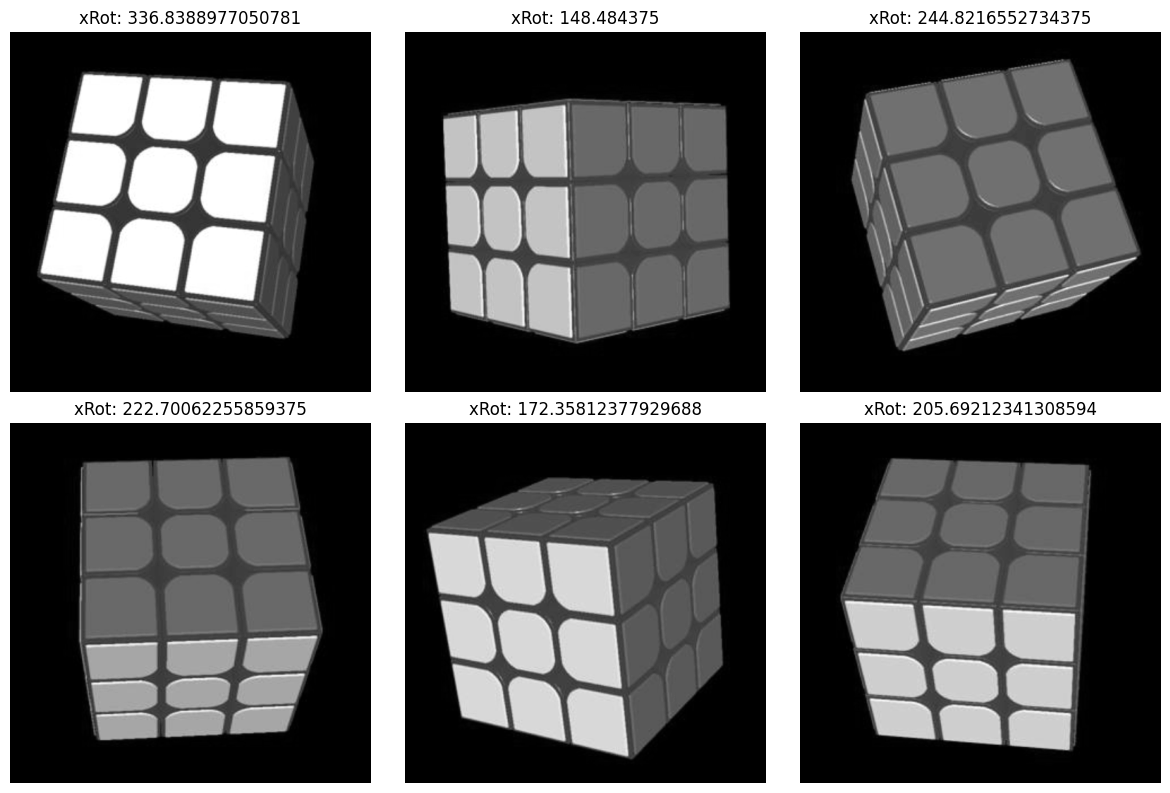

In [16]:
def visualize_probing_dataset(probing_dataset, sample_size= 6):
    """
    Visualizes a probing dataset by displaying a grid of sample images and their corresponding labels.

    Parameters:
    - probing_dataset (torch.utils.data.Dataset): The probing dataset containing image-label pairs.
    - sample_size (int): The number of sample images to display.

    Returns:
    None
    """
    # Calculate the number of rows and columns needed
    cols = 3
    rows = (sample_size + cols - 1) // cols  # Calculate the number of rows required

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

    for i in range(sample_size):
        sample_image, sample_label = probing_dataset[i]

        # Convert the sample image tensor to a NumPy array and transpose it
        sample_image_np = sample_image.permute(1, 2, 0).numpy()

        # Visualize the sample image and label
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]  # Handle single row case
        ax.imshow(sample_image_np, cmap='gray')
        ax.set_title(f'xRot: {sample_label}')
        ax.axis('off')  # Hide axis

    # Hide any unused subplots
    for j in range(i + 1, rows * cols):
        row = j // cols
        col = j % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming probing_dataset is already defined and sample_size is specified
visualize_probing_dataset(probing_dataset, sample_size)


<a name="6-modellarchitektur"></a>
# 6. Modellarchitektur


CNN-Architekturen für die Bildregression waren schwer zu finden, da Bilder typischerweise für Klassifizierungsprobleme verwendet werden.

Glücklicherweise fand ich ein Boilerplate-Repository von einem Doktoranden der Universität Cambridge, Herrn Hugo Hadfield [4], das eine grundlegende Architekturschablone für solche Probleme bereitstellt [5].

Diese Grundlage konnte durch weitere Modifikationen für eine bessere Modularisierung, Protokollierung und Integration in meinen spezifischen Anwendungsfall des Rubik's Cubes erweitert werden.

Das Boilerplate wurde auch erweitert, um die Notwendigkeit zu berücksichtigen, mehrere Aktivierungsfunktionen dynamisch zu testen, ohne sie jedes Mal von Hand schreiben zu müssen, um dem Designkonzept eines "zentralen Konfigurationsobjekts / API" gerecht zu werden.

Diese Klasse `CNNRegression` repräsentiert ein Convolutional Neural Network, das für Bildregressionsaufgaben maßgeschneidert ist. Die Netzwerkarchitektur umfasst:

- Zwei Convolutional-Layer, gefolgt von jeweils einer ReLU-Aktivierung und einem Max-Pooling-Layer.
- Fully-Connected-Layer für den Regressionsausgang.
- Modulares Design für einfache Modifikationen und zusätzliche Protokollierung zur Überwachung des Netzwerks während des Forward-Passes.

Diese Struktur ermöglicht es uns, die Größe des Tensors in jeder Schicht mit der Funktion `pretty_print` zu protokollieren, wodurch wertvolle Einblicke in den internen Zustand des Netzwerks während des Trainings und der Inferenz gewährt werden.

In [17]:
class CNNRegression(nn.Module):
    def __init__(self, image_size : ImageSize , activation_func_name):
        """
        Initializes a CNNRegression object.

        Args:
        - image_size (tuple): A tuple representing the size of the input image in the format (channels, height, width).
        """
        super(CNNRegression, self).__init__()

        self.image_size = image_size

        # activation function
        self.activation_func = getattr(nn.functional, activation_func_name)


        # First Convolutional Layer and Pooling Layer
        self.conv1 = nn.Conv2d(in_channels=self.image_size[0], out_channels=4, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Layer and Pooling Layer
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc_input_size = int(16 * (self.image_size[1] // 4) * (self.image_size[2] // 4))
        self.hidden_layer_size = 128
        self.output_size = 1 # Regression output, so only 1 value if it was classification it would be the number of classes (e.g.len(class_names) )

        self.fc1 = nn.Linear(in_features=self.fc_input_size, out_features=self.hidden_layer_size)
        self.fc2 = nn.Linear(in_features=self.hidden_layer_size, out_features=self.output_size)  # Output 1 value for regression

    def forward(self, x):
        """
        Passes the data through the network.
        There are commented out print statements that can be used to
        check the size of the tensor at each layer. These are very useful when
        the image size changes and you want to check that the network layers are
        still the correct shape.
        """
        # layers = []

        # The batch size does not need to be explicitly referenced within the model definition. It is implicitly managed by the DataLoader and the tensor operations in the model. The DataLoader ensures that tensors are batched, and these batches are processed by the model. The shapes of the tensors during the forward pass reflect the batch size as the first dimension. In this specific example, the batch size of 64 comes from how the DataLoader was set up to batch the data.

        # Forward pass through the first convolutional layer and pooling layer
        x = self.conv1(x)
        # layers.append(["conv1", str(x.size())])
        x = self.activation_func(x)
        # layers.append(["relu1", str(x.size())])
        x = self.pool1(x)
        # layers.append(["pool1", str(x.size())])

        # Forward pass through the second convolutional layer and pooling layer
        x = self.conv2(x)
        # layers.append(["conv2", str(x.size())])
        x = self.activation_func(x)
        # layers.append(["relu2", str(x.size())])
        x = self.pool2(x)
        # layers.append(["pool2", str(x.size())])

        # Flattening the tensor before passing it to fully connected layers
        x = x.view(-1, self.fc_input_size)
        # layers.append(["view1", str(x.size())])

        # Forward pass through the first fully connected layer
        x = self.fc1(x)
        # layers.append(["fc1", str(x.size())])
        x = self.activation_func(x)
        # layers.append(["relu2", str(x.size())])

        # Forward pass through the second fully connected layer
        x = self.fc2(x)
        # layers.append(["fc2", str(x.size())])

        # Use pretty_print to log the layer sizes
        # pretty_print(layers)

        return x


<a name="7-trainingsschleife"></a>
# 7. Trainingsschleife


<a name="71-logger"></a>
## 7.1 Logger


Unten ist die Funktion `update_metrics`, die dazu entworfen wurde, Metriken generisch zu aktualisieren und zurückzugeben, sei es während des Trainings oder der Validierung, um Redundanzen im Code zu vermeiden.

Diese Funktion berechnet den individuellen Verlustwert und akkumuliert den Verlust sowie verschiedene Metriken wie den mittleren absoluten Fehler (MAE), den mittleren quadratischen Fehler (MSE) und den R-Quadrat (R2) für die gegebenen Ausgaben und Ziele, indem die Werte aus dem aktuellen Batch zu den akkumulierten Gesamtwerten hinzugefügt werden.

Sie gibt die akkumulierten Gesamtwerte jedes Mal zurück, die später zum Protokollieren und Überwachen des Trainings- und Validierungsprozesses verwendet werden.

In [18]:
# Function to update and return metrics during training or validation
def update_metrics(outputs, targets, mae, mse, r2, loss, total_loss, total_mae, total_mse, total_r2):
    """
    Update the metrics and loss values for the given outputs and targets.

    Parameters:
    - outputs (Tensor): The predicted outputs.
    - targets (Tensor): The target values.
    - mae (function): The mean absolute error function.
    - mse (function): The mean squared error function.
    - r2 (function): The R-squared function.
    - loss (Tensor): The loss value.
    - total_loss (float): The accumulated loss value.
    - total_mae (float): The accumulated mean absolute error value.
    - total_mse (float): The accumulated mean squared error value.
    - total_r2 (float): The accumulated R-squared value.

    Returns:
    - total_loss (float): The updated accumulated loss value.
    - total_mae (float): The updated accumulated mean absolute error value.
    - total_mse (float): The updated accumulated mean squared error value.
    - total_r2 (float): The updated accumulated R-squared value.
    - loss_value (float): The individual loss value.
    """
    # Calculate individual loss value
    loss_value = loss.item()
    # Accumulate the loss and metrics
    total_loss += loss_value
    total_mae += mae(outputs, targets.unsqueeze(1)).item() # unsqueeze to match the shape of the outputs
    total_mse += mse(outputs, targets.unsqueeze(1)).item() # gives more weight to larger errors, thus penalizing them more heavily compared to MAE
    total_r2 += r2(outputs, targets.unsqueeze(1)).item()

    return total_loss, total_mae, total_mse, total_r2


Unten ist die Funktion `log_metrics`, die Trainingsmetriken in das Verzeichnis `runs` von TensorBoard protokolliert, sodass sie später angezeigt werden können, wenn das TensorBoard-Programm mit `tensorboard --logdir=runs` ausgeführt wird, das einen lokalen Server im Browser oder in VSCode mit der TensorBoard-Erweiterung startet [6] [7].

In [19]:
# Function to log training metrics to TensorBoard
def log_metrics(writer, global_step, loss, train_mae, train_mse, train_r2, inputs, model):
    """
    Logs metrics, images, and weights to TensorBoard.

    Args:
        writer (SummaryWriter): The TensorBoard SummaryWriter object used to log the data.
        global_step (int): The global step of the training process "processing a single batch of data"
        loss (float): The training loss value.
        train_mae (float): The Mean Absolute Error (MAE) value.
        train_mse (float): The Mean Squared Error (MSE) "Penalizes large errors more".
        train_r2 (float): The R-squared (R2) value.
        inputs (torch.Tensor): The input images to the model.
        model (torch.nn.Module): The model being trained.

    Returns:
        None
    """
    # Create a grid of images
    img_grid = torchvision.utils.make_grid(inputs)
    # Log training images, weights, and metrics
    writer.add_image('Training images', img_grid, global_step=global_step)
    writer.add_histogram('fc1', model.fc1.weight, global_step=global_step)
    writer.add_scalar('Training loss', loss, global_step=global_step)
    writer.add_scalar('Training MAE', train_mae, global_step=global_step)
    writer.add_scalar('Training MSE', train_mse, global_step=global_step)
    writer.add_scalar('Training R2', train_r2, global_step=global_step)

Die Funktion `compute_and_log_avg_metrics` berechnet die durchschnittlichen Metriken für eine Epoche und protokolliert sie in TensorBoard.

Dies ist wichtig, um den Trainings- und Validierungsprozess im Laufe der Zeit zu überwachen und Einblicke zu erhalten, wie das Modell im Durchschnitt pro Epoche insgesamt abschneidet.

In [20]:

# Function to compute and log average metrics for an epoch
def compute_and_log_avg_metrics(loader, total_loss, total_mae, total_mse, total_r2, writer, epoch, phase):
    """
    Computes the average metrics (loss, MAE, MSE, R2) and logs them to TensorBoard.

    Parameters:
    - loader (iterable): The data loader.
    - total_loss (float): The total loss accumulated during the epoch.
    - total_mae (float): The total mean absolute error accumulated during the epoch.
    - total_mse (float): The total mean squared error accumulated during the epoch.
    - total_r2 (float): The total R-squared value accumulated during the epoch.
    - writer (SummaryWriter): The TensorBoard writer.
    - epoch (int): The current epoch number.
    - phase (str): The phase of the training (e.g., 'train', 'val').

    Returns:
    - avg_loss (float): The average loss.
    - avg_mae (float): The average mean absolute error.
    - avg_mse (float): The average mean squared error.
    - avg_r2 (float): The average R-squared value.
    """
    # Calculate average values
    avg_loss = total_loss / len(loader)
    avg_mae = total_mae / len(loader)
    avg_mse = total_mse / len(loader)
    avg_r2 = total_r2 / len(loader)

    # Log average metrics to TensorBoard
    if writer:
        writer.add_scalar(f'{phase}/Loss', avg_loss, epoch)
        writer.add_scalar(f'{phase}/MAE', avg_mae, epoch)
        writer.add_scalar(f'{phase}/MSE', avg_mse, epoch)
        writer.add_scalar(f'{phase}/R2', avg_r2, epoch)

    return avg_loss, avg_mae, avg_mse, avg_r2

Derzeit funktioniert es nicht auf der lokalen Maschine aufgrund der Nichtverfügbarkeit einer GPU / Kompatibilitätsproblemen mit Pytorch, da TensorBoard ursprünglich für TensorFlow entwickelt wurde. Dies wird in den nächsten Versionen behandelt. Das Ziel ist es, die 3D-Projektorfunktion in TensorBoard zu nutzen.

In [21]:
# # Function to log embeddings periodically to TensorBoard
# def log_embeddings_periodically(model, val_loader, writer, device, epoch, global_step):
#     """
#     Logs embeddings periodically using a given model, validation data loader, writer, device, epoch, and global step.

#     Parameters:
#     - model (nn.Module): The model used for generating embeddings.
#     - val_loader (DataLoader): The validation data loader.
#     - writer (SummaryWriter): The writer object for logging embeddings.
#     - device (torch.device): The device on which the model and data should be loaded.
#     - epoch (int): The current epoch number.
#     - global_step (int): The global step number.

#     Returns:
#     - None
#     """
#     if writer and epoch % 1 == 0:
#         inputs, targets = next(iter(val_loader))
#         inputs, targets = inputs.to(device), targets.to(device)
#         outputs = model(inputs)
#         embeddings = outputs.cpu().detach().numpy()
#         metadata = targets.cpu().detach().numpy()
#         writer.add_embedding(embeddings, metadata=metadata, label_img=inputs, global_step=global_step)

<a name="72-trainieren-validieren"></a>
## 7.2 Trainieren & Validieren


Die Funktion `train_epoch` ist dafür ausgelegt, eine Epoche des Trainings für ein vorgegebenes Modell durchzuführen.

Diese Funktion übernimmt den Forward-Pass, die Verlustberechnung, den Backward-Pass, die Gewichtsaktualisierungen und die Protokollierung der Metriken für jeden Batch im Trainingsdatensatz.

Am Ende jeder Schleife dieser Funktion werden alle Modellparameter optimiert, aktualisiert und zur Visualisierung protokolliert. Dies geschieht Batch für Batch für alle Batches in einer Epoche, für alle Epochen.

In [22]:
# Function to perform one epoch of training
def train_epoch(model, train_loader, criterion, optimizer, mae, mse, r2, device, writer, global_step):
    """
    Trains the model for one epoch.

    Args:
        model (nn.Module): The model to be trained.
        train_loader (DataLoader): The data loader for the training dataset.
        criterion (loss function): The loss function used for training.
        optimizer (optimizer): The optimizer used for updating the model's weights.
        mae (Metric): The mean absolute error metric.
        mse (Metric): The mean squared error metric.
        r2 (Metric): The R-squared metric.
        device (torch.device): The device on which the model and data are located.
        writer (SummaryWriter): The summary writer for logging metrics.
        global_step (int): The global step counter.

    Returns:
        tuple: A tuple containing the training loss, mean absolute error, mean squared error,
               R-squared value, and the updated global step counter.
    """
    model.train()  # Set the model to training mode
    train_loss, train_mae, train_mse, train_r2 = 0.0, 0.0, 0.0, 0.0  # Initialize metrics

    with tqdm(total=len(train_loader), desc='Training', unit='batch') as pbar:
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets.unsqueeze(1))  # Compute the loss, unsqueeze so targets"labels" match the shape of the outputs for comparison
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            # Update and log metrics
            train_loss, train_mae, train_mse, train_r2 = update_metrics(
                outputs, targets, mae, mse, r2, loss, train_loss, train_mae, train_mse, train_r2)

            if writer and global_step % 10 == 0:
                log_metrics(writer, global_step, train_loss, train_mae, train_mse, train_r2, inputs, model)

            pbar.set_postfix({'loss': train_loss})  # Update progress bar
            pbar.update(1)
            global_step += 1

    return train_loss, train_mae, train_mse, train_r2, global_step

Die Funktion `validate_epoch` ist dafür ausgelegt, eine Epoche der Validierung für ein gegebenes Modell durchzuführen. Sie evaluiert das Modell anhand des Validierungsdatensatzes, ohne die Modellparameter zu aktualisieren (ohne Backpropagation oder Optimierung).

Diese Funktion übernimmt den Forward-Pass, die Verlustberechnung und die Protokollierung der Metriken für jeden Batch im Validierungsdatensatz.

In [23]:
# Function to perform one epoch of validation
def validate_epoch(model, val_loader, criterion, mae, mse, r2, device):
    """
    Perform validation for one epoch.

    Args:
        model (torch.nn.Module): The model to be evaluated.
        val_loader (torch.utils.data.DataLoader): The validation data loader.
        criterion: The loss function.
        mae: The mean absolute error metric.
        mse: The mean squared error metric.
        r2: The R-squared metric.
        device: The device to run the evaluation on.

    Returns:
        Tuple[float, float, float, float]: The validation loss, mean absolute error,
        mean squared error, and R-squared value.
    """
    model.eval()  # Set the model to evaluation mode
    val_loss, val_mae, val_mse, val_r2 = 0.0, 0.0, 0.0, 0.0  # Initialize metrics

    with torch.no_grad():  # No need to compute gradients during validation
        with tqdm(total=len(val_loader), desc='Validation', unit='batch') as pbar:
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, targets.unsqueeze(1))  # Compute the loss, unsqueeze to match the shape of the outputs to the targets "labels" they woill be compared with

                # Update and log metrics
                val_loss, val_mae, val_mse, val_r2 = update_metrics(
                    outputs, targets, mae, mse, r2, loss, val_loss, val_mae, val_mse, val_r2)

                pbar.set_postfix({'val_loss': val_loss})  # Update progress bar
                pbar.update(1)

    return val_loss, val_mae, val_mse, val_r2


Die Funktion `train_network` ist dafür ausgelegt, ein Convolutional Neural Network (CNN) für Regressionsaufgaben unter Verwendung der angegebenen Hyperparameter zu trainieren. Diese Funktion verwaltet den gesamten Trainings- und Validierungsprozess, einschließlich der Protokollierung von Metriken in TensorBoard und der Verfolgung der besten Modellleistung.

In [24]:
# Main function to train the network
def train_network(model_params : Hparams, model, train_loader, val_loader, device='cpu', writer=None):
    """
    Train the CNN regression model.

    Args:
        model_params (Hparams): Hyperparameters for the model.
        model (nn.Module): The CNN regression model.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader): DataLoader for the validation data.
        device (str, optional): Device to train the model on. Defaults to 'cpu'.
        writer (SummaryWriter, optional): TensorBoard writer for logging. Defaults to None.

    Returns:
        nn.Module: Trained model.
    """

    # Unpack hyperparameters from the dictionary
    epochs = model_params['epochs']
    learn_rate = model_params['learn_rates']
    batch_size = model_params['batch_sizes']
    img_pixel_val = model_params['img_pixel_vals']
    activation = model_params['activations']

    # Use pretty print to log the hyperparameters
    print("Training Model with those Specific hyperparameters: ")
    pretty_print([
        ["Epochs", epochs],
        ["Learning Rate", learn_rate],
        ["Batch Size", batch_size],
        ["Image Size", img_pixel_val],
        ["Activation", activation]
    ])

    # Move the model to the specified device
    model.to(device)

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    # Initialize metrics
    mae = MeanAbsoluteError().to(device)
    mse = MeanSquaredError().to(device)
    r2 = R2Score().to(device)

    global_step = 0  # Initialize global step for TensorBoard logging, an epoch is one complete pass through the entire training dataset. During each epoch, the model processes every training example exactly once. In contrast, the global_step usually refers to a single update to the model's parameters, which occurs after processing a single batch of data.

    lowest_val_mse = float('inf')  # Initialize the lowest validation MSE to infinity to ensure that any valid MSE value encountered during the first validation pass will be smaller
    best_epoch = -1  # Initialize the best epoch to an invalid value

    for epoch in range(epochs):
        # Train for one epoch
        train_loss, train_mae, train_mse, train_r2, global_step = train_epoch(
            model, train_loader, criterion, optimizer, mae, mse, r2, device, writer, global_step)

        # Compute and log average training metrics
        avg_train_loss, avg_train_mae, avg_train_mse, avg_train_r2 = compute_and_log_avg_metrics(
            train_loader, train_loss, train_mae, train_mse, train_r2, writer, epoch, 'Train')

        # Validate for one epoch
        val_loss, val_mae, val_mse, val_r2 = validate_epoch(
            model, val_loader, criterion, mae, mse, r2, device)

        # Compute and log average validation metrics
        avg_val_loss, avg_val_mae, avg_val_mse, avg_val_r2 = compute_and_log_avg_metrics(
            val_loader, val_loss, val_mae, val_mse, val_r2, writer, epoch, 'Validation')

        # Check and update the lowest validation MSE since it is the most important metric in our use case
        if avg_val_mse < lowest_val_mse:
            lowest_val_mse = avg_val_mse
            best_epoch = epoch + 1 # Epochs start at 0, so add 1 to get the actual epoch number for human readability

        # Print epoch results
        print(f'Model name : {model.__class__.__name__}, Epoch [ {epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, '
              f'Train MAE: {avg_train_mae:.4f}, Validation MAE: {avg_val_mae:.4f}, '
              f'Train MSE: {avg_train_mse:.4f}, Validation MSE: {avg_val_mse:.4f}, '
              f'Train R2: {avg_train_r2:.4f}, Validation R2: {avg_val_r2:.4f}')

        # Log embeddings periodically for projector tab in tensorboard currently disabled due to performance issues
        # log_embeddings_periodically(model, val_loader, writer, device, epoch, global_step)

        # Print the lowest validation MSE after training
        print(f'Lowest Validation MSE: {lowest_val_mse:.4f} at epoch {best_epoch}')

        # Log hyperparameters and metrics to TensorBoard
        if writer:
            writer.add_hparams(
                {"learn_rate": learn_rate, "batch_size": batch_size, "epochs": epochs, "img_pixel_val": img_pixel_val, "activation": activation},
                {
                    "train_loss": avg_train_loss,
                    "val_loss": avg_val_loss,
                    "train_mae": avg_train_mae,
                    "val_mae": avg_val_mae,
                    "train_mse": avg_train_mse,
                    "val_mse": avg_val_mse,
                    "train_r2": avg_train_r2,
                    "val_r2": avg_val_r2,
                },
            )

    # Close the TensorBoard writer if it exists
    if writer:
        writer.close()

    return model

<a name="8-protokollierung-plotten"></a>
# 8. Protokollierung & Plotten


<a name="81-protokollierung"></a>
## 8.1 Protokollierung


Die Funktion `generate_log_dir` erstellt einen Verzeichnispfad für das Logging basierend auf einem Basisverzeichnis und Hyperparametern. Dies ist nützlich, um Protokolle verschiedener Experimente zu organisieren und sicherzustellen, dass jede Menge von Hyperparametern ihr eigenes einzigartiges Protokollverzeichnis erhält.

Dies wird einen einzigartigen Verzeichnispfad wie `runs/EPOCHS_10_BATCH_SIZES_64_IMG_PIXEL_VALS_128_LEARN_RATES_0.01_relu_T2024-07-21_08-18-49.pth` zum Speichern von Protokollen generieren.

In [25]:
def generate_log_dir(base_dir, hparams : Hparams):
    """
    Generate a log directory path based on the given base directory and hyperparameters.

    Parameters:
    base_dir (str): The base directory where the log directory will be created.
    hparams (Hparams): The hyperparameters used to generate the dynamic part of the log directory.

    Returns:
    str: The path of the generated log directory.

    """
    # Generate the dynamic part of the log directory
    dynamic_dir = "_".join([f"{key.upper()}_{val}" for key, val in hparams.items()])

    # timestamp added to prevent overwriting
    dynamic_part = dynamic_dir +'_T'+ datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    # Combine with base directory and current timestamp
    log_dir_path = os.path.join(base_dir, dynamic_part)

    # Ensure the base directory exists
    os.makedirs(base_dir, exist_ok=True)

    return log_dir_path


Die Funktion `track_execution_time` verfolgt die Ausführungszeit einer Funktion und speichert die Ergebnisse in einer CSV-Datei.

Dies ist nützlich, um zu überwachen, wie lange verschiedene Modelltrainingseinheiten dauern, und ihre Dauer zu vergleichen. Diese Funktion bietet eine umfassende Möglichkeit, die Ausführungszeit von Trainingsläufen zu verfolgen und zu protokollieren. Dies hilft, den Trainingsprozess effizient zu überwachen und zu optimieren. Außerdem hilft sie dabei, abzuschätzen, wie lange jedes Experiment dauert, sodass ich meine nächsten Experimente entsprechend planen kann und im Voraus weiß, wie lange ein Experiment dauern könnte.

In [26]:
def track_execution_time(start_time : float, end_time : float, save_state_sict_path : str, hparams_grid : Hparams, base_dir : str='execution-times'):
    """
    Track the execution time of a function and save the results to a CSV file.

    Parameters:
    - start_time (float): The start time of the execution.
    - end_time (float): The end time of the execution.
    - save_state_sict_path (str): The file path to save the state of the execution.
    - hparams_grid (Hparams): The hyperparameters grid used for the execution.
    - base_dir (str): The base directory to save the execution times CSV file. Default is 'execution-times'.

    Returns:
    None
    """
    # Create the base directory if it does not exist
    os.makedirs(base_dir, exist_ok=True)

    # Function to format hyperparameter values
    def format_hparam_value(value):
        if isinstance(value, list):
            if len(value) > 1:
                return ','.join(map(str, value))
            else:
                return str(value[0])
        return str(value)

    # Generate a file name based on the hyperparameters grid
    hparams_str = '-'.join([f"{key}-{format_hparam_value(value).replace(' ', '')}" for key, value in hparams_grid.items()])
    csv_file = os.path.join(base_dir, f"{hparams_str}.csv")

    # Calculate execution time and format it
    execution_time = end_time - start_time
    execution_time_str = str(timedelta(seconds=execution_time)).split('.')[0]  # Remove milliseconds for readability

    start_time_str = datetime.fromtimestamp(start_time).strftime('%Y-%m-%d %H:%M:%S')
    end_time_str = datetime.fromtimestamp(end_time).strftime('%Y-%m-%d %H:%M:%S')

    cumulative_time = timedelta(seconds=0)
    if os.path.isfile(csv_file):
        df = pd.read_csv(csv_file)
        cumulative_time = pd.to_timedelta(df['Execution Time (HH:MM:SS)']).sum()

    cumulative_time += timedelta(seconds=execution_time)
    cumulative_time_str = str(cumulative_time).split('.')[0]

    file_exists = os.path.isfile(csv_file)
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(['Model File Path', 'Execution Time (HH:MM:SS)', 'Start Time', 'End Time', 'Cumulative Duration'])
        writer.writerow([save_state_sict_path, execution_time_str, start_time_str, end_time_str, cumulative_time_str])

    print("Execution time :")
    pretty_print([["Model File Path", save_state_sict_path], ["Execution Time", execution_time_str], ["Start Time", start_time_str], ["End Time", end_time_str], ["Cumulative Duration", cumulative_time_str]])


<a name="82-plotten"></a>
## 8.2 Plotten


Die Funktion visualize_predictions visualisiert die Vorhersagen eines Modells auf einem Validierungsdatensatz.

Sie gibt auch den prozentualen Fehler gemäß der Formel aus, sodass man eine Intuition dafür bekommen, wie gut das Modell abschneidet:

$ \text{Percentage Error} = \left| \frac{\text{True Value} - \text{Predicted Value}}{\text{True Value}} \right| \times 100 \% $

In [27]:
def visualize_predictions(model, val_loader, num_samples=8):
    """
    Visualizes the predictions made by a given model on a validation dataset.

    Args:
        model (torch.nn.Module): The trained model.
        val_loader (torch.utils.data.DataLoader): The validation data loader.
        device (torch.device): The device to perform computations on.
        num_samples (int, optional): The number of samples to visualize. Defaults to 8.
    """
    model.eval()
    samples = random.sample(range(len(val_loader.dataset)), num_samples)

    fig, axes = plt.subplots(num_samples // 2, 2, figsize=(10, num_samples * 2))
    axes = axes.flatten()

    for i, idx in enumerate(samples):
        image, true_label = val_loader.dataset[idx]

        print(f"Image shape: {image.shape}, label type: {true_label.dtype}")

        with torch.no_grad():
            prediction = model(image.unsqueeze(0).to(next(model.parameters()).device)).cpu().item()  # Ensure image is in a batch format

        image = image.permute(1, 2, 0)  # Move channels to the end for plotting compatibility

        # Calculate percentage error
        percentage_error = abs((true_label - prediction) / true_label) * 100

        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"True: {true_label:.2f}, Pred: {prediction:.2f}, Error: {percentage_error:.2f}%")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


Die Funktion plot_and_save_metrics extrahiert und visualisiert Trainingsmetriken aus den TensorBoard-Ereignisprotokollen mithilfe des TensorBoard EventAccumulator, sodass sie während der Code-Ausführung angezeigt und in einem Verzeichnis gespeichert werden können. Dies benötigte ich als Schnellzugriffsübersicht für den Überblick über das Training.

In [28]:
def plot_and_save_metrics(tensorboard_log_dir_path : str, metrics_file_path : str):
    """
    Plot and save metrics from TensorBoard logs.

    Parameters:
    tensorboard_log_dir_path (str): The directory path where the TensorBoard logs are stored.
    metrics_file_path (str): The full path and file name with extension where the metrics plots will be saved.

    Returns:
    None
    """
    ea = event_accumulator.EventAccumulator(tensorboard_log_dir_path)
    ea.Reload()

    metrics = ['Train/Loss', 'Validation/Loss', 'Train/MAE', 'Validation/MAE', 'Train/MSE', 'Validation/MSE', 'Train/R2', 'Validation/R2']
    fig, axes = plt.subplots(len(metrics) // 2, 2, figsize=(15, 20))
    axes = axes.flatten()

    for ax, metric in zip(axes, metrics):
        events = ea.Scalars(metric)
        steps = [e.step for e in events]
        values = [e.value for e in events]
        ax.plot(steps, values, label=metric)
        ax.set_title(metric)
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    print(f"Saving metrics plot to {metrics_file_path}")
    fig.savefig(metrics_file_path)  # Save the figure to a file
    plt.show()

<a name="9-modellgenerierung"></a>
# 9. Modellgenerierung


<a name="91-speichern-laden"></a>
## 9.1 Speichern & Laden


Die Funktion save_model speichert das Zustandsdiktat eines trainierten Modells in einem angegebenen Dateipfad. Dies ist nützlich, um das Modell zu speichern, sodass es später geladen und verwendet werden kann, ohne es erneut trainieren zu müssen.

In [29]:
def save_model(trained_model, save_state_sict_path='model.pth'):
    """
    Save the trained model's state dictionary to a file.

    Parameters:
    - trained_model: The trained model object.
    - save_state_sict_path: The path to save the model's state dictionary. Default is 'model.pth'.
    """
    print(f'Saving model to {save_state_sict_path}')
    torch.save(trained_model.state_dict(), save_state_sict_path)

Die Funktion load_model lädt das Zustandsdiktat eines Modells von einem angegebenen Dateipfad und aktualisiert eine gegebene Modellinstanz mit dem geladenen Zustandsdiktat. Dies ermöglicht es, die Parameter eines trainierten Modells wiederherzustellen und es für Inferenz oder weiteres Training zu verwenden.

In [30]:
def load_model(model_to_update, load_state_dict_path):
    """
    Loads a model from a given state dictionary file.

    Args:
        model_to_update (torch.nn.Module): The model to update with the loaded state dictionary.
        load_state_dict_path (str): The path to the state dictionary file.

    Returns:
        torch.nn.Module: The loaded model.

    Raises:
        FileNotFoundError: If the model file is not found at the specified path.
    """
    print(f'Loading model from {load_state_dict_path}')
    # Check if model file exists
    if not os.path.exists(load_state_dict_path):
        raise FileNotFoundError(f"Model file not found at path {load_state_dict_path}")

    # Load the state dictionary from the file
    state_dict = torch.load(load_state_dict_path)

    # Get the number of output features in the 'fc1' layer of the state dictionary
    fc1_weight_shape = state_dict['fc1.weight'].shape

    num_output_features = fc1_weight_shape[0]
    img_pixel_val = model_to_update.image_size[1]

    if num_output_features != img_pixel_val:
        raise ValueError(f"Number of output features in the 'fc1' layer of the state dictionary ({num_output_features}) and img_pixel_val of the untrained model ({img_pixel_val}) do not match. Please update the img_pixel_val of the untrained model in the model_config file to {num_output_features}.")

    # Load the state dictionary into the model and capture the combination process in a variable for mismatch checking
    combining_keys = model_to_update.load_state_dict(state_dict, strict=False)

    # check if there are any missing or unexpected keys when loading the model
    if combining_keys.missing_keys:
        print(f'Missing keys when loading the model: {combining_keys.missing_keys}')
    if combining_keys.unexpected_keys:
        print(f'Unexpected keys when loading the model: {combining_keys.unexpected_keys}')

    loaded_model = model_to_update # now the model is updated from state_dict and checked for missing or unexpected keys it can be used for inference

    return loaded_model

<a name="92-programmmodi"></a>
## 9.2 Programmmodi


Die Funktion run_train_mode ist der Modus, in dem das Programm ein neues Modell trainiert, anstatt ein Vorhandenes zu laden. Sie übernimmt den gesamten Prozess des Trainings eines maschinellen Lernmodells, einschließlich Protokollierung, Visualisierung und Memory clean-up. Sie verfolgt die Ausführungszeit, protokolliert Trainingsmetriken in TensorBoard, speichert das trainierte Modell und visualisiert Vorhersagen.

In [31]:
def run_train_mode(untrained_model, train_loader, val_loader, model_specific_hparams : Hparams, device):
    """
    Runs the training mode for a machine learning model.

    Args:
        untrained_model: The untrained model to be trained.
        train_loader: The data loader for the training dataset.
        val_loader: The data loader for the validation dataset.
        model_specific_hparams: The hyperparameters specific to the model.
        device: The device to be used for training.

    Returns:
        trained_model: The trained model.
    """
    # Start execution logger tracking time
    start_time = time.time()

    # Initialize the summary writer for TensorBoard logging
    tensorboard_base_dir = 'runs'  # Default directory name for TensorBoard logs
    tensorboard_log_dir_path = generate_log_dir(tensorboard_base_dir, model_specific_hparams)
    writer = SummaryWriter(log_dir=tensorboard_log_dir_path)

    # Visualize model architecture in TensorBoard
    images, _ = next(iter(train_loader))  # TensorBoard needs a batch of images to visualize the model without labels
    writer.add_graph(untrained_model, images.to(device))

    # Train the model
    trained_model = train_network(model_params=model_specific_hparams, model=untrained_model, device=device, train_loader=train_loader, val_loader=val_loader, writer=writer)

    # Plot and save metrics after training
    metrics_base_dir = 'metrics'
    metrics_file_path = generate_log_dir(metrics_base_dir, model_specific_hparams) + '.png'
    plot_and_save_metrics(tensorboard_log_dir_path, metrics_file_path)

    # Define model file path
    models_base_dir = 'models'
    save_state_sict_path = generate_log_dir(models_base_dir, model_specific_hparams) + '.pth'

    # Save the model
    save_model(trained_model, save_state_sict_path)

    # Visualize predictions
    print("Visualizing predictions after training...")
    visualize_predictions(trained_model, val_loader)

    # Close the writer
    writer.close()

    # Clean up memory
    cleanup(train_loader, val_loader, trained_model)

    # End tracking time
    end_time = time.time()

    # Track and write execution time to CSV
    track_execution_time(start_time, end_time, save_state_sict_path, Hparams_grid)  # Pass the global Hparams_grid


Die Funktion run_eval_mode führt den Bewertungsmodus für ein trainiertes Modell aus. Sie lädt das Modell aus einem gespeicherten Zustandsdiktat, visualisiert Vorhersagen auf dem Validierungsdatensatz und räumt anschließend den Speicher auf.

In [32]:
def run_eval_mode(untrained_model, load_state_dict_path, val_loader, device):
    """
    Runs the evaluation mode for a trained model.

    Args:
        untrained_model (nn.Module): The untrained model architecture.
        load_state_dict_path (str): The path to the saved state dictionary of the trained model.
        val_loader (DataLoader): The data loader for the validation dataset.
        device (torch.device): The device to run the evaluation on.

    Returns:
        None
    """
    # Load the model
    trained_model = load_model(untrained_model, load_state_dict_path)
    trained_model.to(device)

    # Visualize predictions
    print("Visualizing predictions for the loaded model...")
    visualize_predictions(trained_model, val_loader)

    # Clean up memory
    cleanup(val_loader, trained_model)

<a name="93-speicherverwaltung"></a>
## 9.3 Speicherverwaltung


Die Funktion cleanup ist dafür ausgelegt, den Speicher freizugeben, indem sie Plots schließt, den GPU-Cache leert, angegebene Objekte löscht und die Garbage Collection erzwingt.

In [33]:
def cleanup(*args):
    """
    Clean up memory by closing plots, clearing GPU cache, deleting objects passed as arguments such as loaders and models, and forcing garbage collection.

    Args:
        *args: Any number of objects to be deleted for freeing up memory.
    """
    # Close all plots
    plt.close('all')

    # Clear GPU cache if applicable
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    elif hasattr(torch, 'mps'):
        # Checks if the system has MPS (Metal Performance Shaders) support, which is relevant for Mac devices
        if torch.backends.mps.is_available():
            torch.mps.empty_cache()

    # Delete each object passed as argument typically loaders and models
    for obj in args:
        del obj

    # Force garbage collection to free memory
    gc.collect()


<a name="94-ausführung"></a>
## 9.4 Ausführung


Die Funktion generate_combinations generiert alle möglichen Kombinationen von Hyperparametern aus einem gegebenen Raster. Dies ist nützlich für die Hyperparameter-Optimierung, da es eine systematische Erkundung verschiedener Konfigurationen ermöglicht, um die am besten geeignete Menge an Hyperparametern zu finden.

In [34]:
def generate_combinations(grid: Hparams):
    """
    Generate all possible combinations of hyperparameters from a given grid.

    Parameters:
    grid (Hparams): A dictionary containing the hyperparameter grid.

    Returns:
    list: A list of dictionaries representing all possible combinations of hyperparameters.
    """
    keys, values = zip(*grid.items()) # Unpacks the dictionary into two tuples: keys containing the hyperparameter names and values containing lists of possible values for each hyperparameter

    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)] # generates the Cartesian product of the hyperparameter values, resulting in all possible combinations. For each combination, zip(keys, v) pairs the hyperparameter names with the values, and dict(zip(keys, v)) creates a dictionary representing that combination
    return combinations


Die main-Funktion koordiniert die Ausführung des Programms, indem sie bestimmt, ob der Bewertungsmodus oder der Trainingsmodus basierend auf dem bereitgestellten booleschen Parameter ausgeführt werden soll. Sie initialisiert Datensätze, Modellinstanzen und führt den entsprechenden Modus (Training oder Bewertung) entsprechend aus.

Running in evaluation mode : True
Training model with hyperparameters grid :
+----------------+----------+
| Description    | Value    |
+================+==========+
| epochs         | [400]    |
+----------------+----------+
| batch_sizes    | [32]     |
+----------------+----------+
| img_pixel_vals | [128]    |
+----------------+----------+
| learn_rates    | [0.001]  |
+----------------+----------+
| activations    | ['relu'] |
+----------------+----------+
Creating a dataset with the following parameters:
+-----------------+---------+
| Description     |   Value |
+=================+=========+
| img_pixel_val   |   128   |
+-----------------+---------+
| batch_size      |    32   |
+-----------------+---------+
| test_split_size |     0.2 |
+-----------------+---------+
Loading model from models/EPOCHS_400_BATCH_SIZES_32_IMG_PIXEL_VALS_128_LEARN_RATES_0.001_ACTIVATIONS_relu_T2024-07-24_08-33-45.pth
Visualizing predictions for the loaded model...
Image shape: torch.Size([1, 128, 1

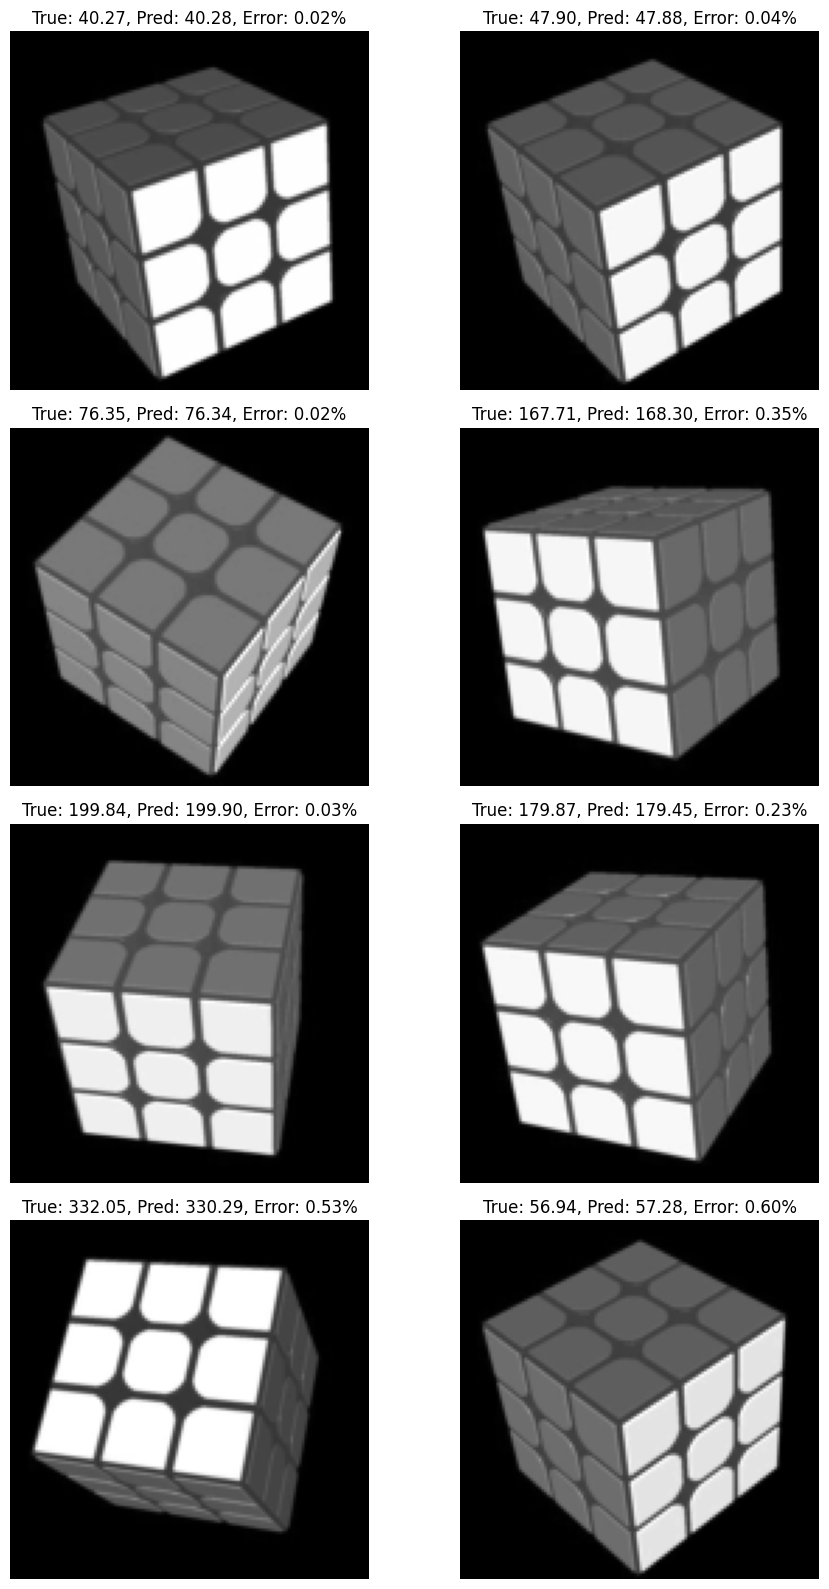

In [35]:
def main(eval_mode : bool):
    """
    The main function of the program.

    Parameters:
    - eval_mode (bool): A boolean indicating whether the program is running in evaluation mode or training mode.

    Returns:
    None
    """
    print("Running in evaluation mode :", eval_mode)
    print("Training model with hyperparameters grid :")
    pretty_print([[key, str(value)] for key, value in Hparams_grid.items()])

    for model_specific_hparams in generate_combinations(Hparams_grid):

        image_size = (1, model_specific_hparams['img_pixel_vals'], model_specific_hparams['img_pixel_vals'])

        # Initialize dataset and dataloaders
        dataset = TransformedDataset(model_specific_hparams=model_specific_hparams)
        train_loader, val_loader = dataset.train_loader, dataset.val_loader

        # Initialize a model instance with random params
        untrained_model = CNNRegression(image_size, model_specific_hparams['activations']).to(device)

        # Visualize initial model with random params for debugging purposes
        # print("Visualizing predictions *BEFORE* training...")
        # visualize_predictions(untrained_model, val_loader)

        if eval_mode:
            run_eval_mode(untrained_model, load_state_dict_path, val_loader, device)
        else :
            run_train_mode(untrained_model,train_loader,val_loader, model_specific_hparams, device)

if __name__ == '__main__':
    main(eval_mode)


<a name="kommentar"></a>
# 10. Kommentar


Eine Kombination aus manueller Protokollierung mit Print-Anweisungen, Matplotlib und TensorBoard wurde verwendet, da die manuelle Protokollierung schnelle Einblicke ermöglichte, während TensorBoard eine tiefere Analyse bot. Beides wurde benötigt, um das Modell korrekt zu verstehen und zu aktualisieren.

Es war jedoch schwierig, die manuellen Protokolle zu verfolgen, daher wurde sichergestellt, dass sie in separaten Verzeichnissen bleiben und ihre Dateien Zeitstempel in ihren Namen bekommen, um ein Überschreiben zu vermeiden. Außerdem wurde ein improvisiertes Backup-Verzeichnis erstellt, um nützliche Experimente zu speichern.


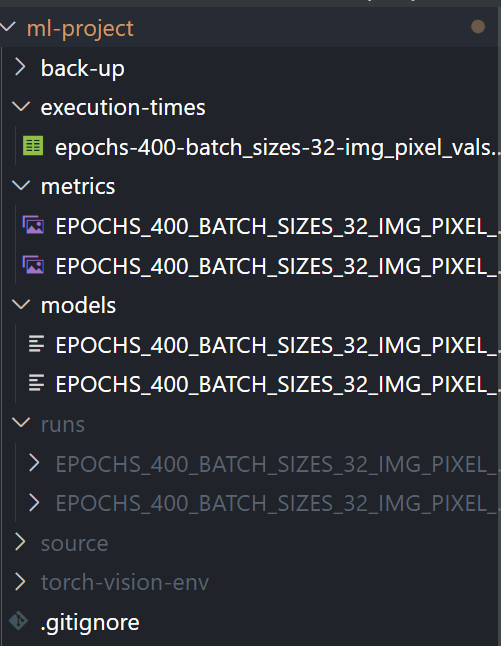

Zusätzlich wurde ein Logger für die Ausführungszeit hinzugefügt, um basierend auf früheren Experimenten abzuschätzen, wie lange zukünftige Experimente voraussichtlich dauern werden.

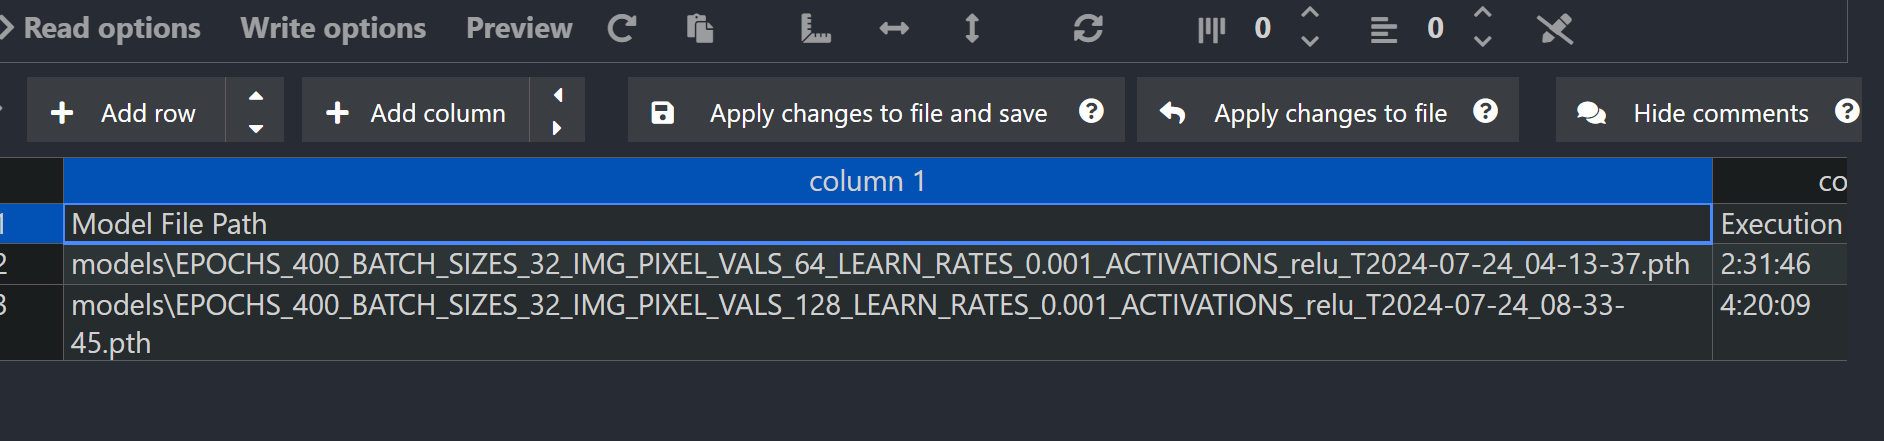

Das Ziel war es, die Fehlermarge auf weniger als 1 % zu reduzieren, was Tage des Ausprobierens und Abstimmens erforderte. Dieser Prozess wurde durch das zentrale Konfigurationsdesign erleichtert, das es ermöglichte, alles dynamisch zu steuern und zu protokollieren, bis dieses Ziel schließlich erreicht werden konnte.

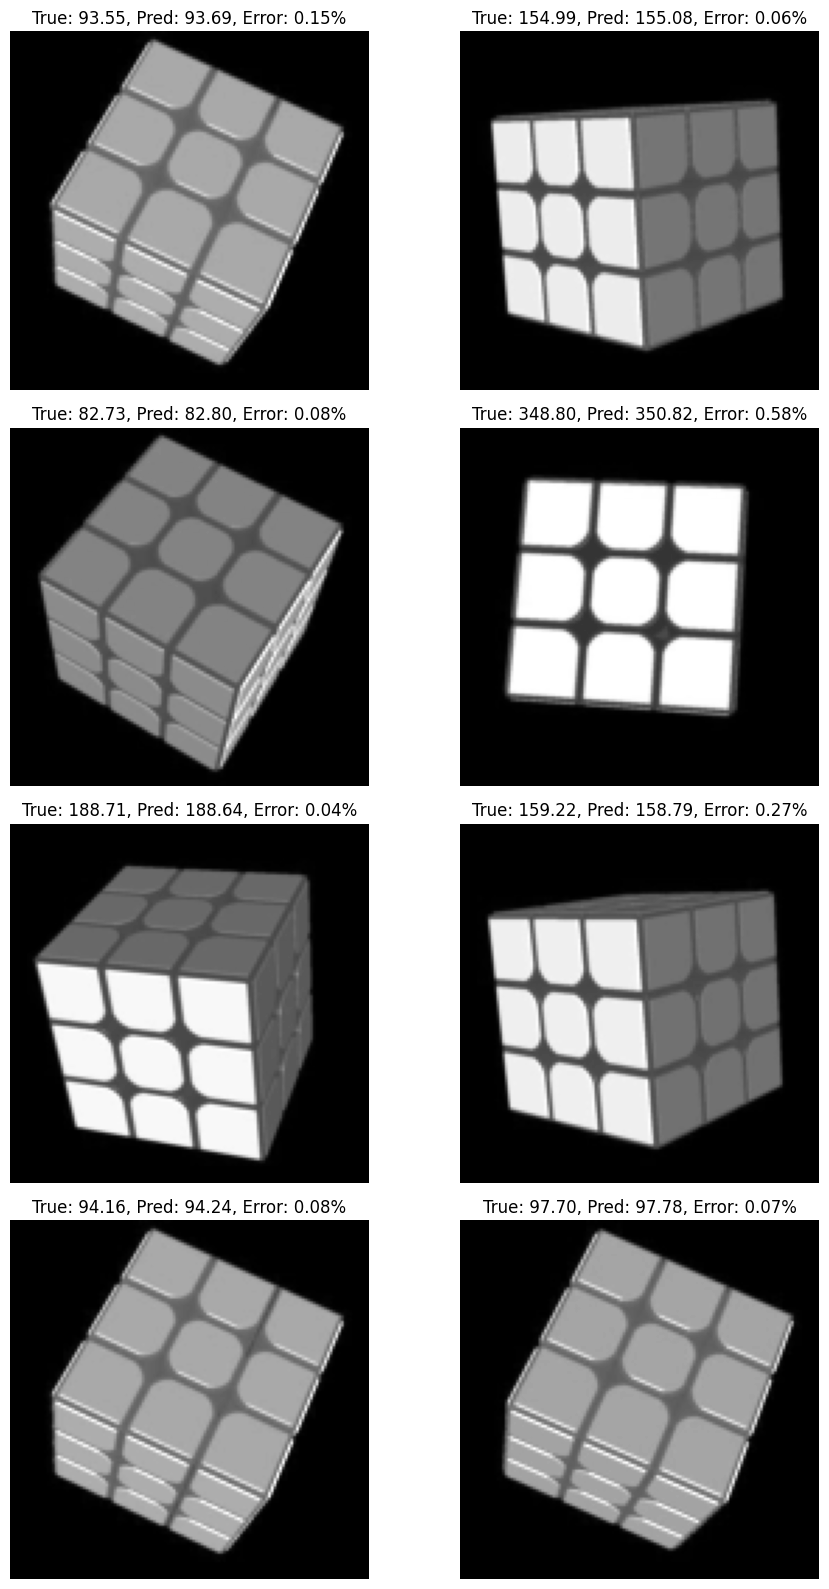

Alle Metriken wurden mit besonderem Augenmerk auf die Validierungs-MSE verfolgt, da dies die Hauptmetrik für die Bewertung der Code-Challenge war.

1. **Train/Loss und Validation/Loss**: Beide Verlustkurven zeigen schnelles Lernen in den ersten Epochen. Der Trainingsverlust stabilisiert sich, während der Validierungsverlust variabler, aber abwärts tendiert, was auf effektives Lernen und gute Generalisierung hinweist.

2. **Train/MAE und Validation/MAE**: Die MAE-Kurven zeigen ein ähnliches Muster, mit abnehmender und stabilisierender Trainings-MAE sowie einer variableren, aber verbesserten Validierungs-MAE. Dies spiegelt den abnehmenden durchschnittlichen Fehler des Modells wider.

3. **Train/MSE und Validation/MSE**: Die MSE-Kurven zeigen anfangs einen starken Rückgang. Die Trainings-MSE stabilisiert sich auf einem niedrigen Wert, während die Validierungs-MSE trotz Variabilität eine Abnahme der Fehler anzeigt.

4. **Train/R2 und Validation/R2**: Die R2-Kurven zeigen, dass die Erklärungskraft des Modells schnell zunimmt. Die Trainings-R2 nähert sich 1 an, und die Validierungs-R2 bleibt konsistent über 0,9, was auf gute Generalisierung hinweist.

Diese Ergebnisse belegen, dass die Modellparameter effektiv sind und minimales Overfitting vorliegt, unterstützt durch die Konvergenz und Stabilisierung der Metriken.

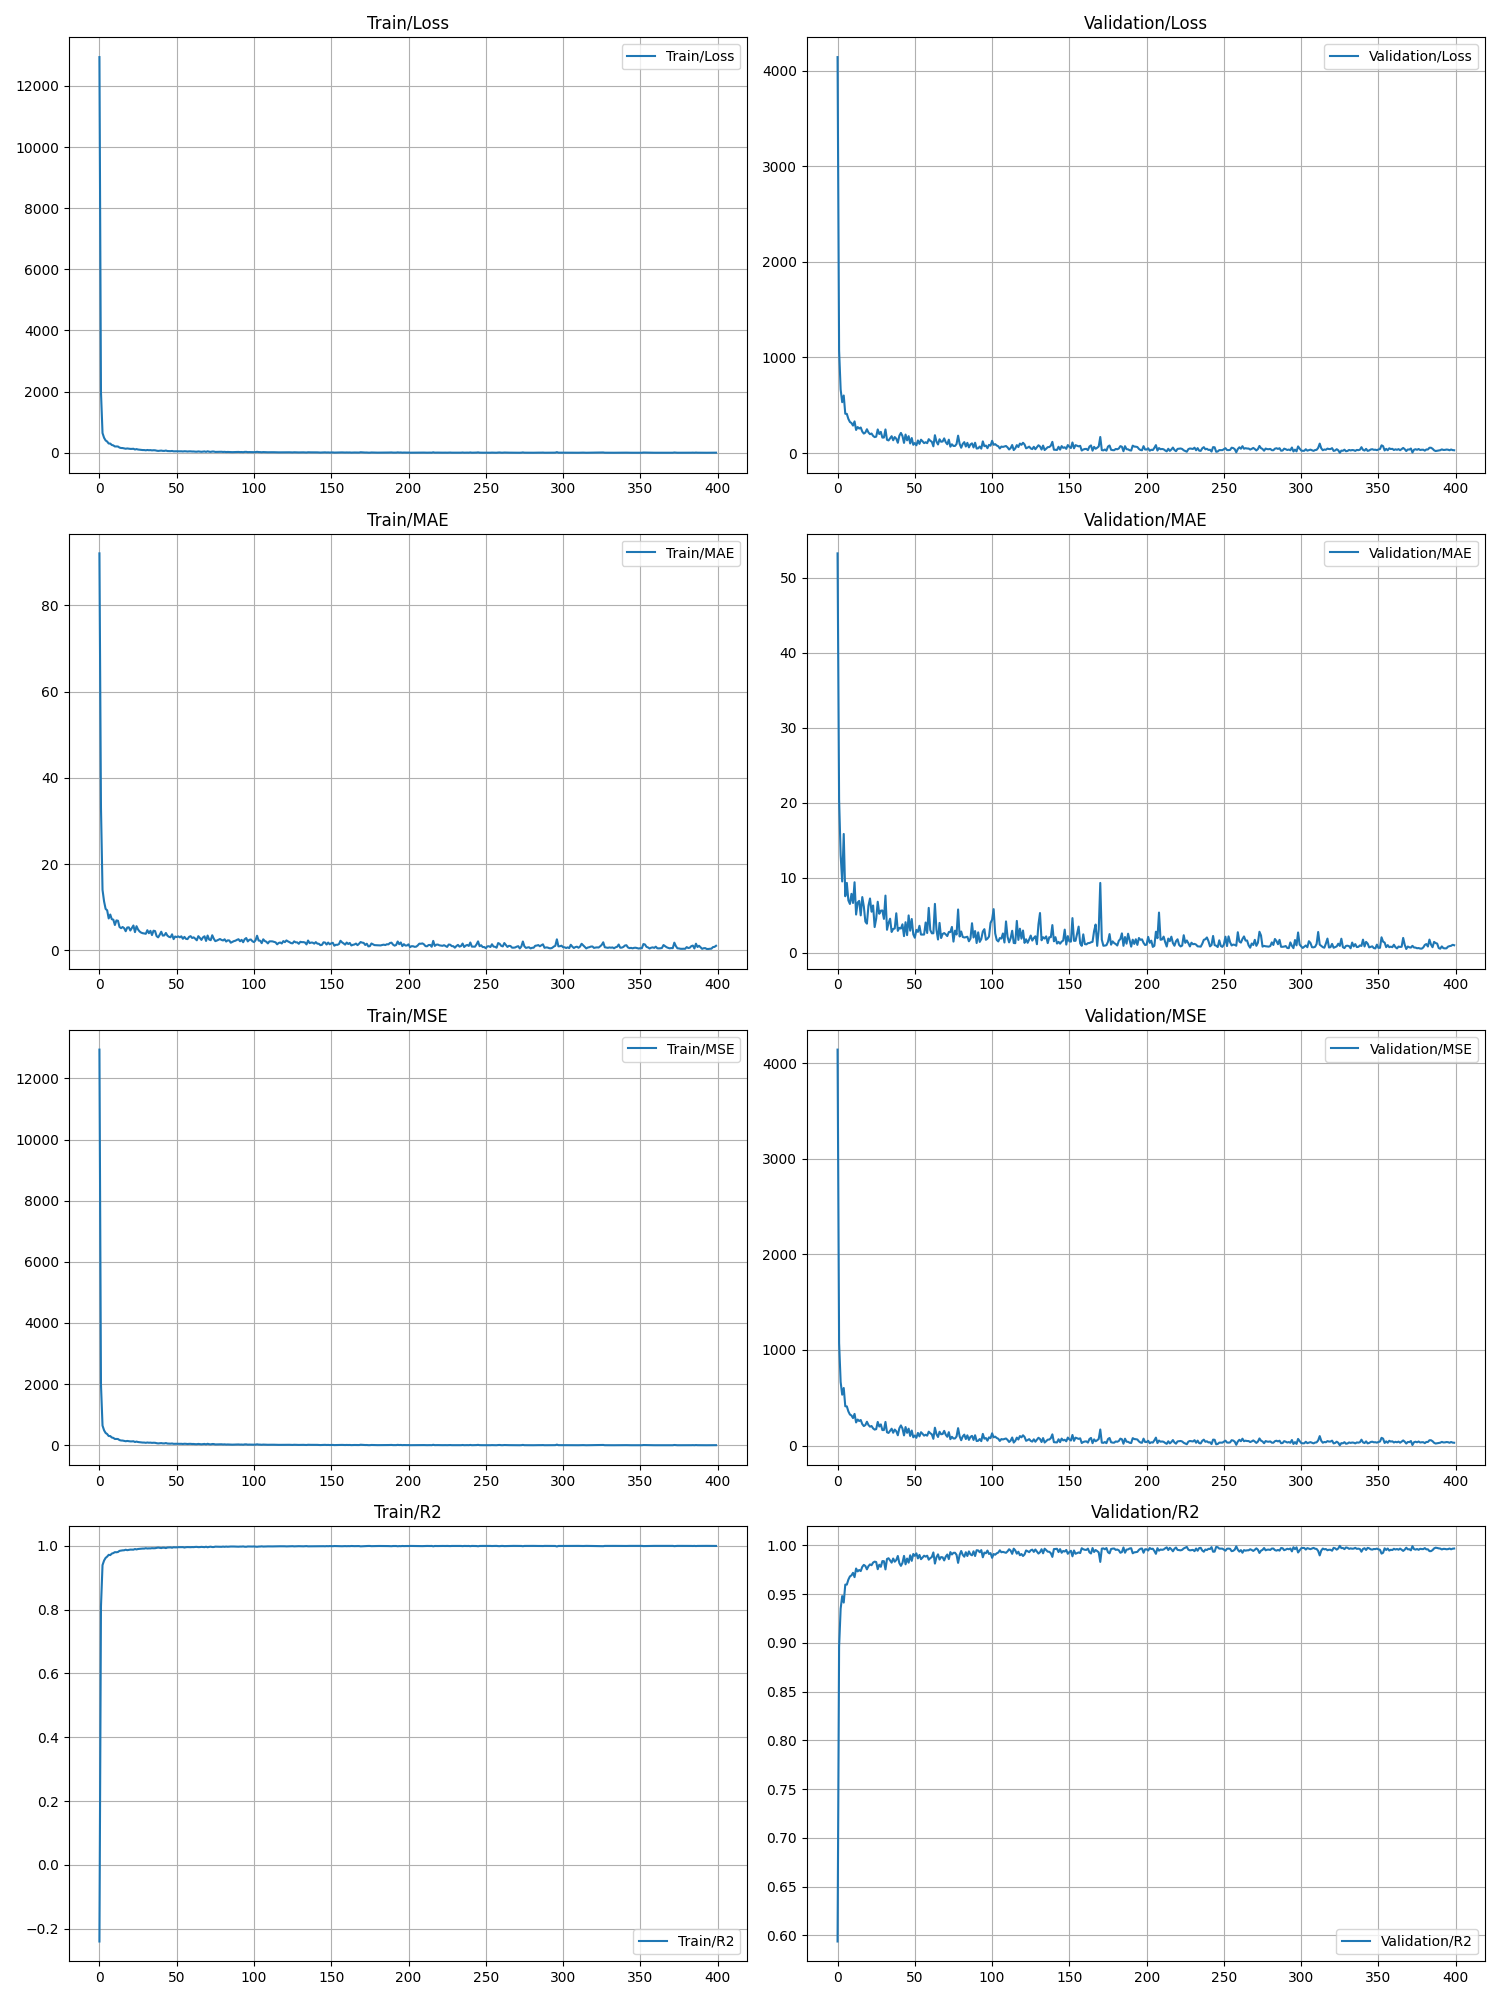

Hier sind Screenshots aus dem finalen TensorBoard:

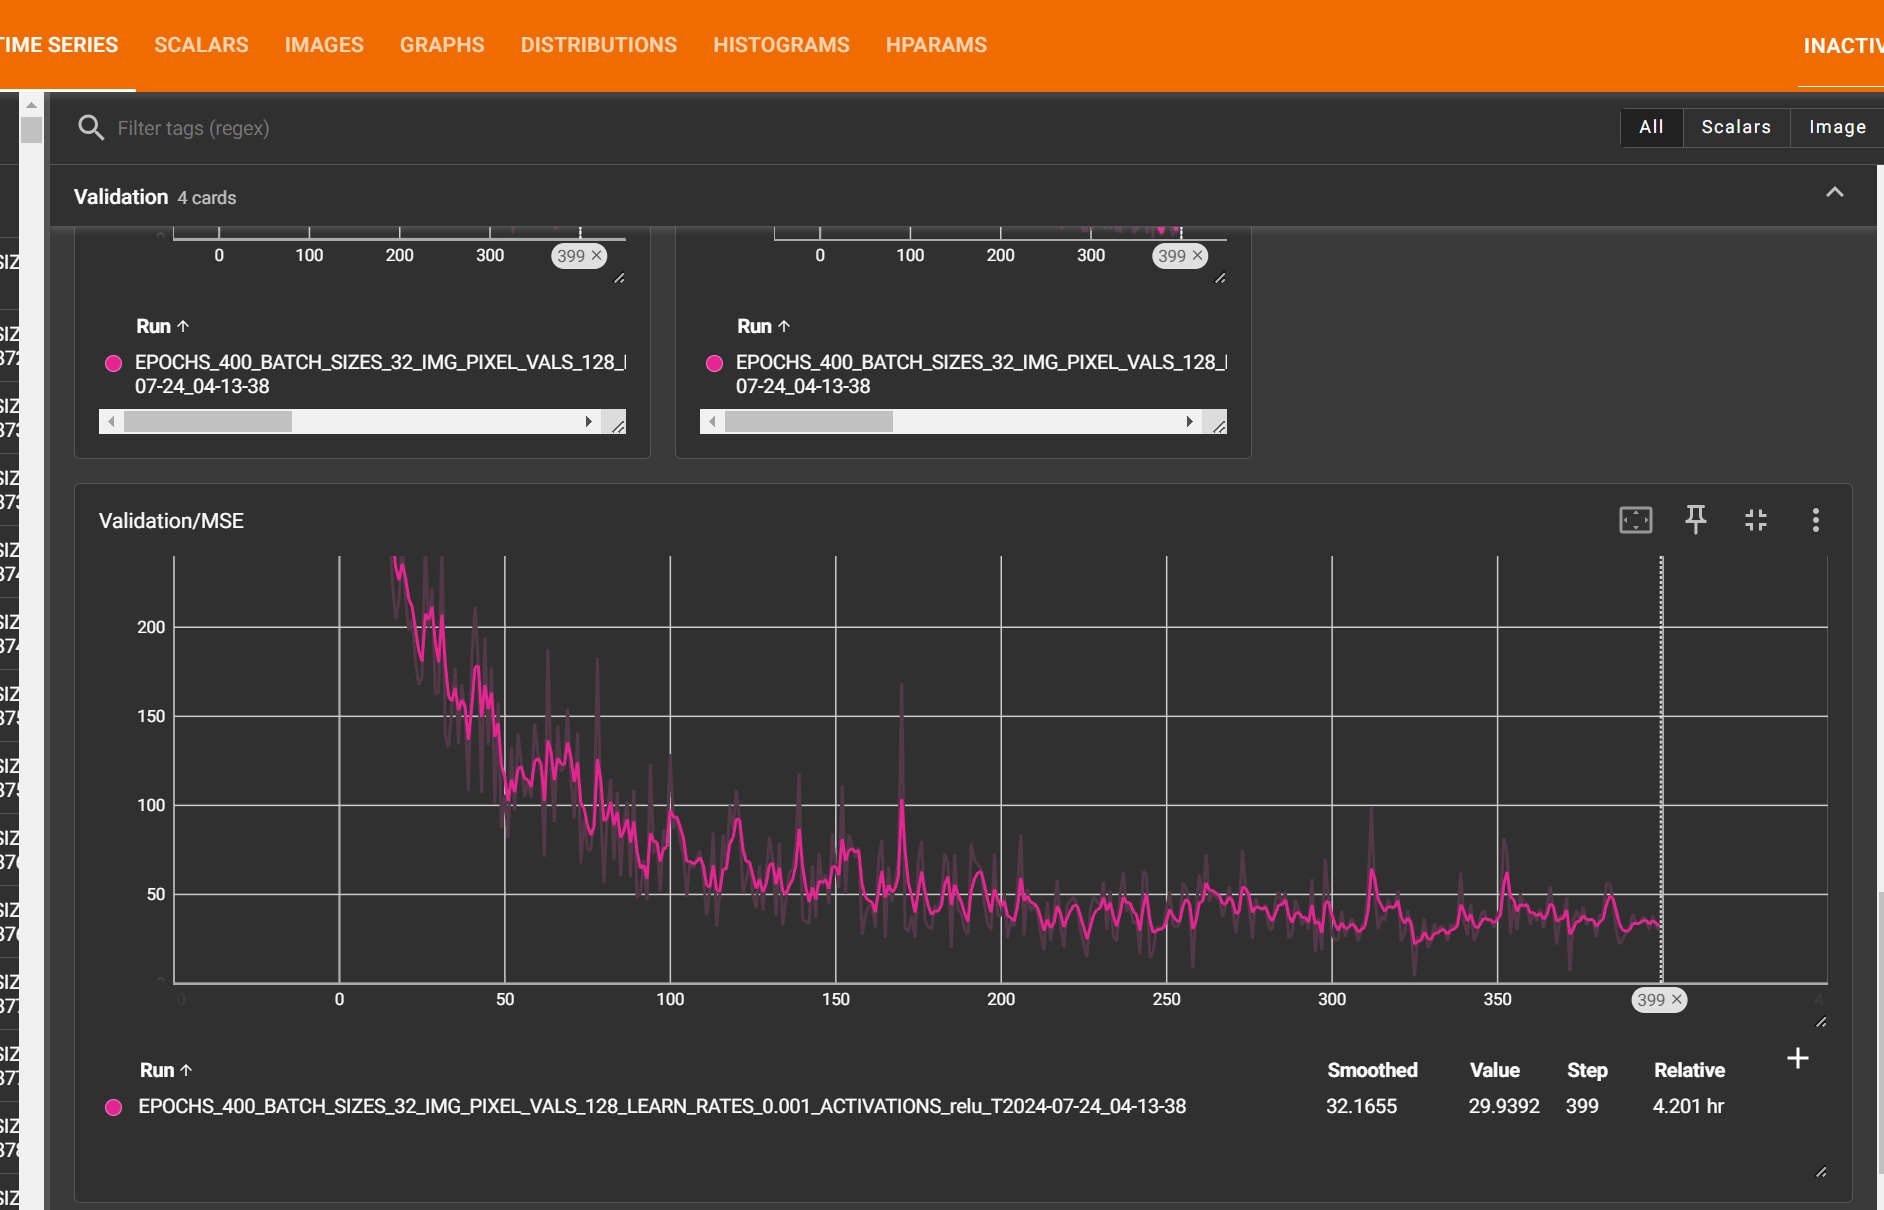

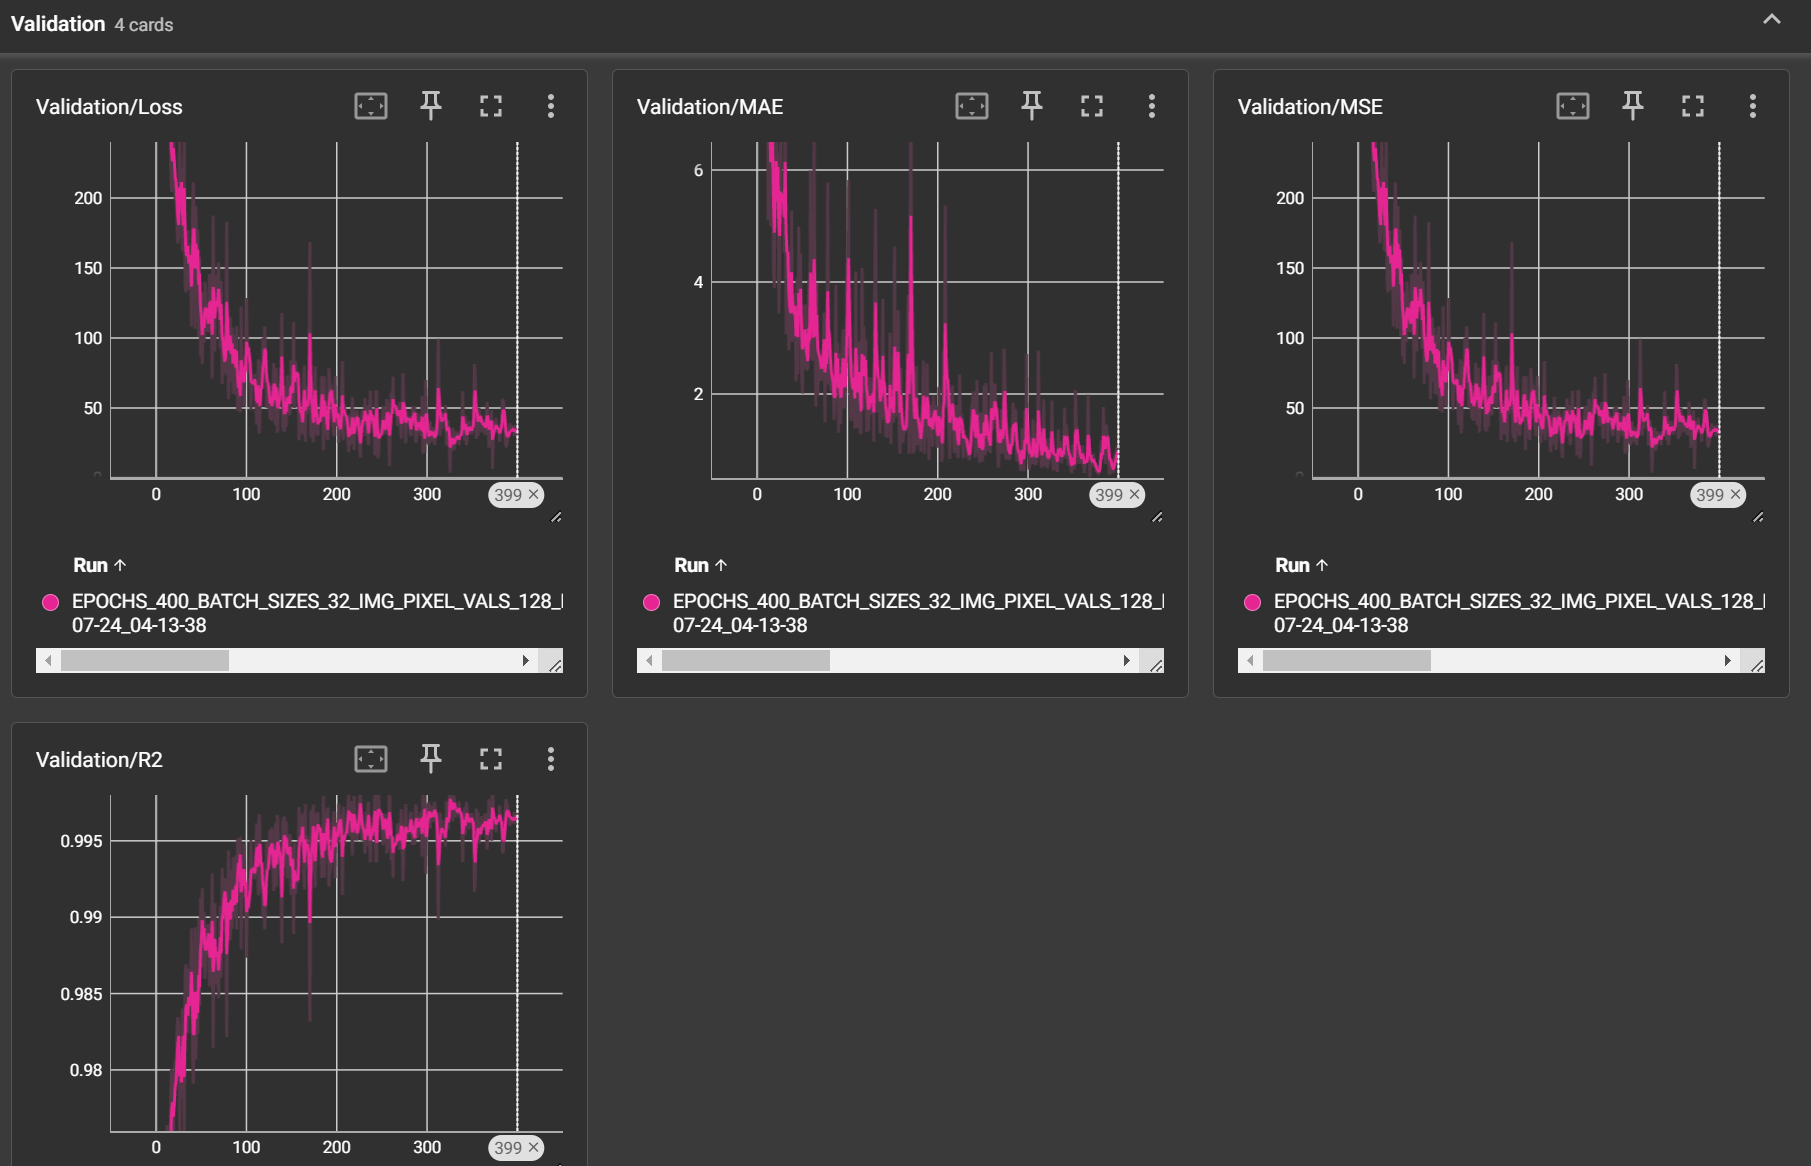

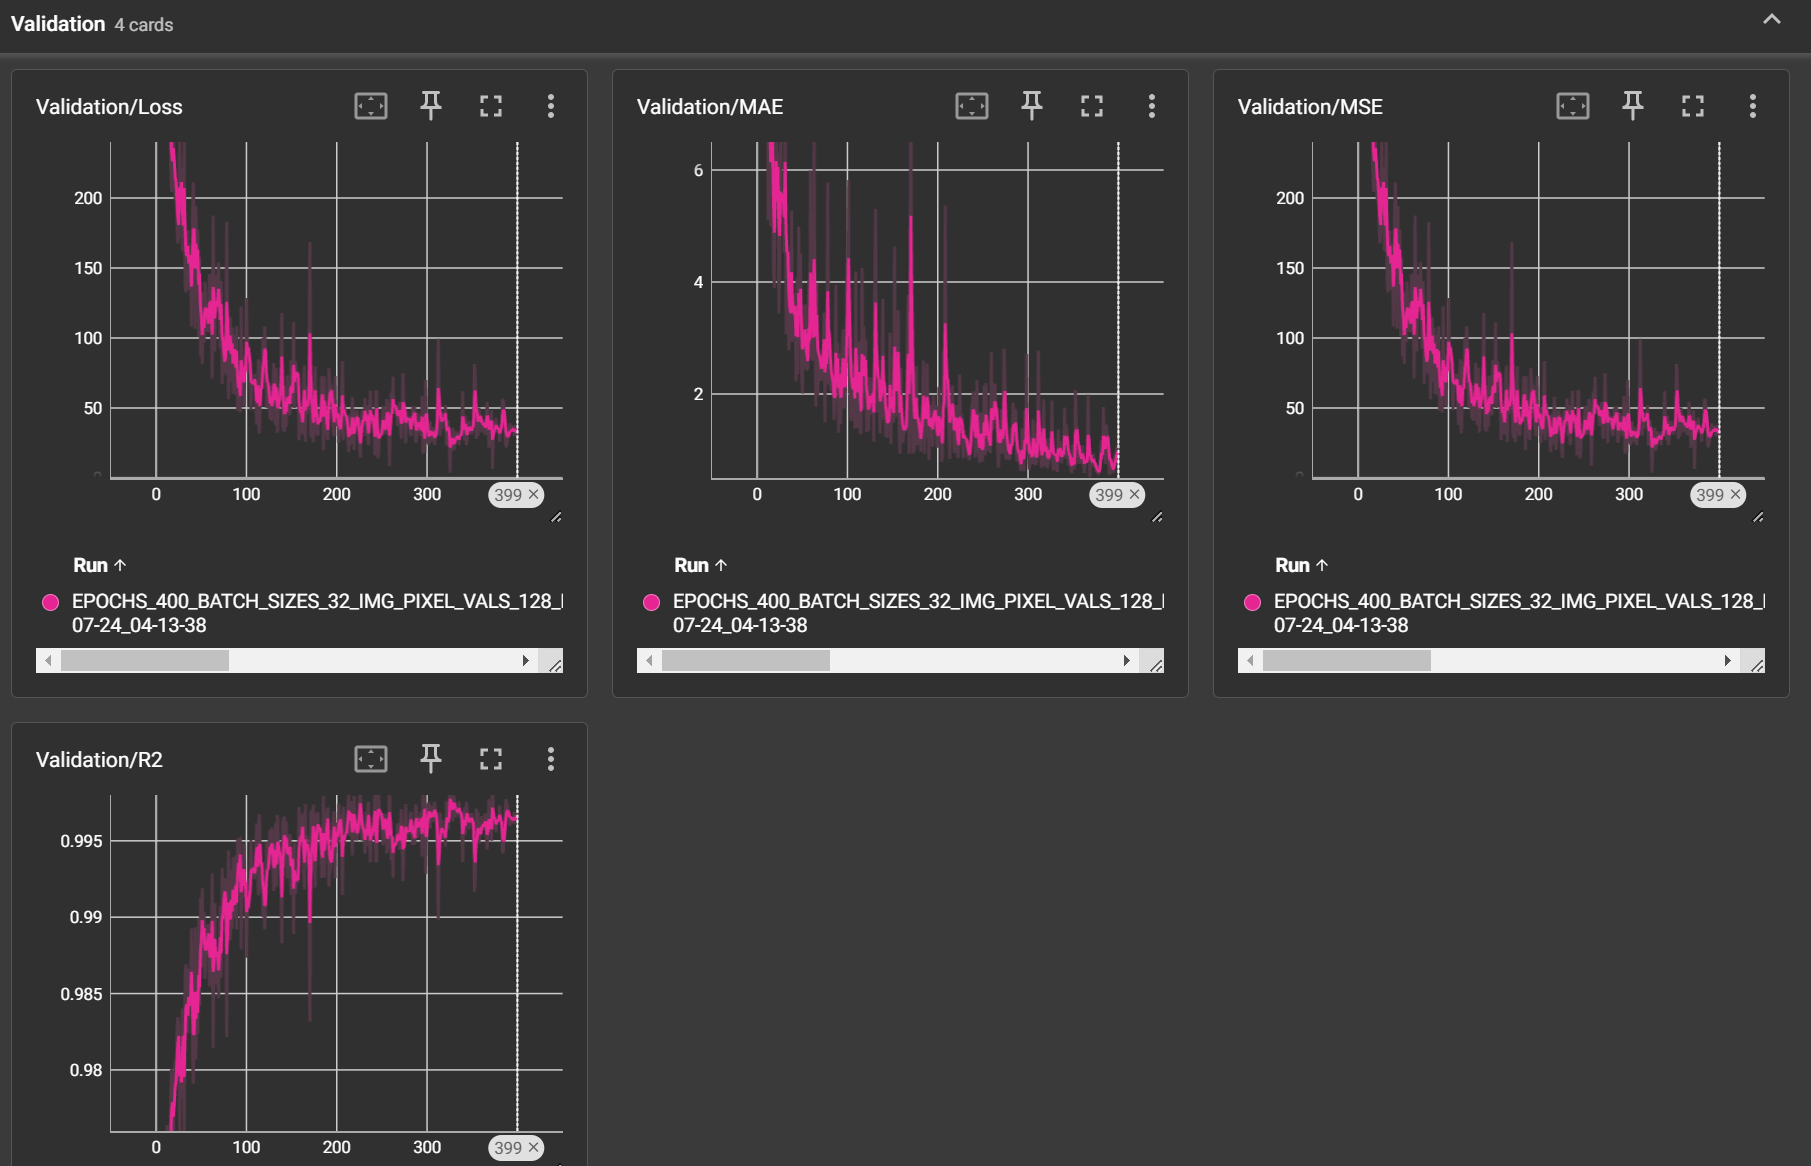

Dieser Graph zeigt die Verteilung der Parameterwerte in der ersten vollständig verbundenen Schicht (fc1) nach 400 Trainings-Epochen mit einer Batchgröße von 32. Der scharfe Gipfel in der Mitte weist auf eine hohe Konzentration der Parameterwerte um null hin.

Die Konvergenz der Parameter gegen null bedeutet, dass die Modellparameter durch das Training so angepasst wurden, dass die Verlustfunktion effektiv minimiert wird. Dies deutet auf ein gut regularisiertes Modell hin, bei dem die Gewichte nicht übermäßig groß sind, was eine Overfitting verhindert und eine bessere Generalisierung auf ungesehene Daten fördert. Die zentralisierte Verteilung um null zeigt auch, dass das Modell gelernt hat, die Gewichte effizient auszugleichen, was zu stabilem und effektivem Lernen beiträgt.

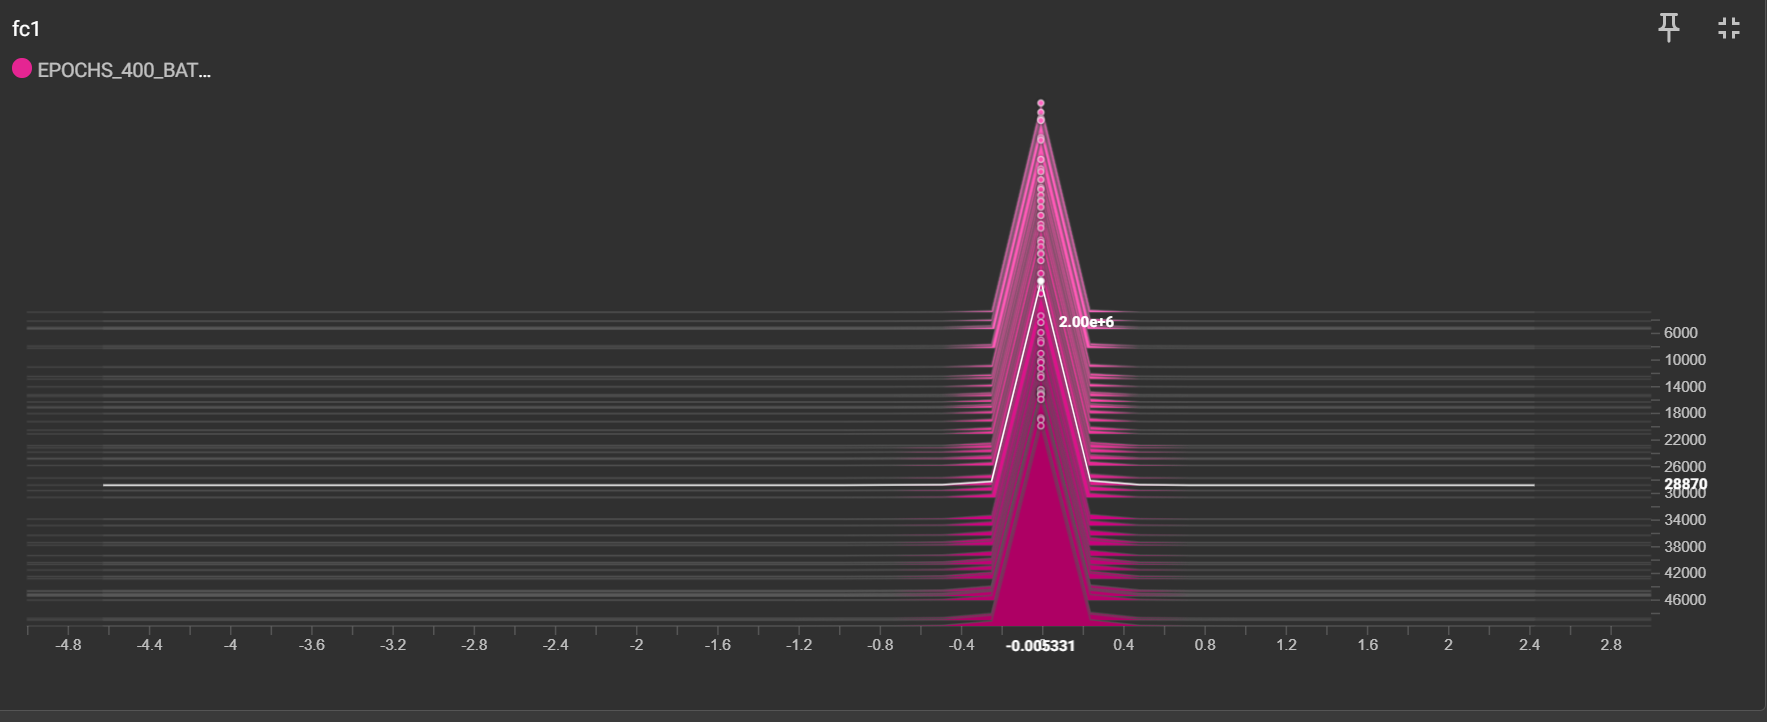
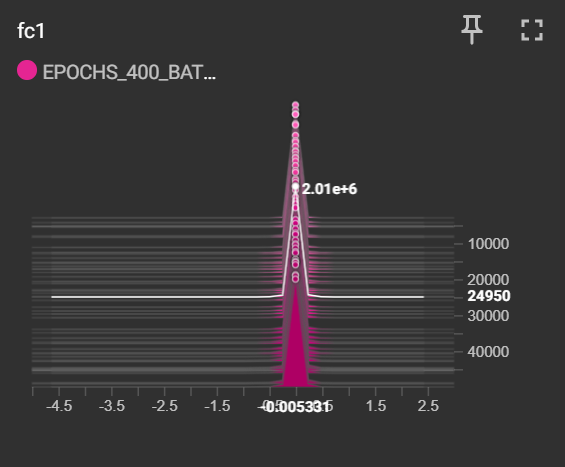

Es ist wichtig zu erwähnen, dass es nicht ausreichte, dass das Hyper-Raster dynamisch war und darauf ausgelegt war, eine automatische Abstimmung aller möglichen Hyperparameter zu suchen, wie ursprünglich gedacht.

Der Prozess umfasste viel iteratives Ausprobieren, gemischt mit Intuition, wie das nächste Experiment zu gestalten ist, während gleichzeitig Zeit und Rechenaufwand berücksichtigt wurden.

128 Pixel wurden als die beste Größe erachtet, und eine Batch-Größe von 32 erwies sich als effektiv. Dies war jedoch nur der Fall, als die Lernrate auf 0,001 reduziert wurde. Bei den Aktivierungsfunktionen erwiesen sich ReLU, leaky ReLU und ELU als die besten. ReLU und seine Variationen wurden ausgewählt, weil sie die modernen Standardaktivierungsfunktionen für hidden layers darstellen [8], ReLU war am Ende die beste.

Es ist erwähnenswert, dass das Training nach etwa 30 Epochen mit zufriedenstellenden Ergebnissen beendet werden könnte. Aus Neugier wurde das Training jedoch auf 400 Epochen verlängert, was zu leicht besseren Ergebnissen führte, aber nicht notwendig war. Die Verlustfunktion MSELoss wurde ebenfalls verwendet (Diese Verlustfunktion ist für Regressionsprobleme wie die Vorhersage der Orientierung des Rubik's Cube geeignet, da sie größere Fehler stärker bestraft und zu genaueren Vorhersagen führt) und der Optimierer Adam. 

In zukünftigen Versionen könnten noch mehr Verlustfunktionen und Optimierer ausprobiert werden, jedoch wurde aufgrund von Berechnungs- und Zeitbeschränkungen hier aufgehört und die Ergebnisse als zufriedenstellend empfunden.

Anbei sind Beispiele für solche iterative Experimente. 

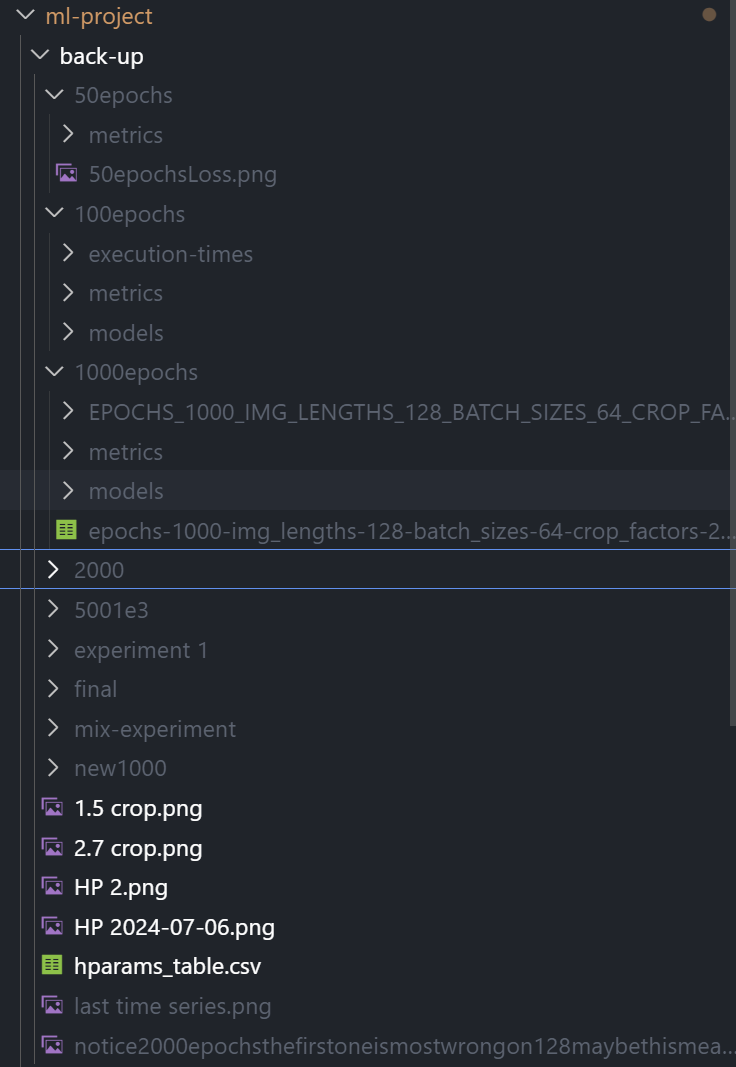
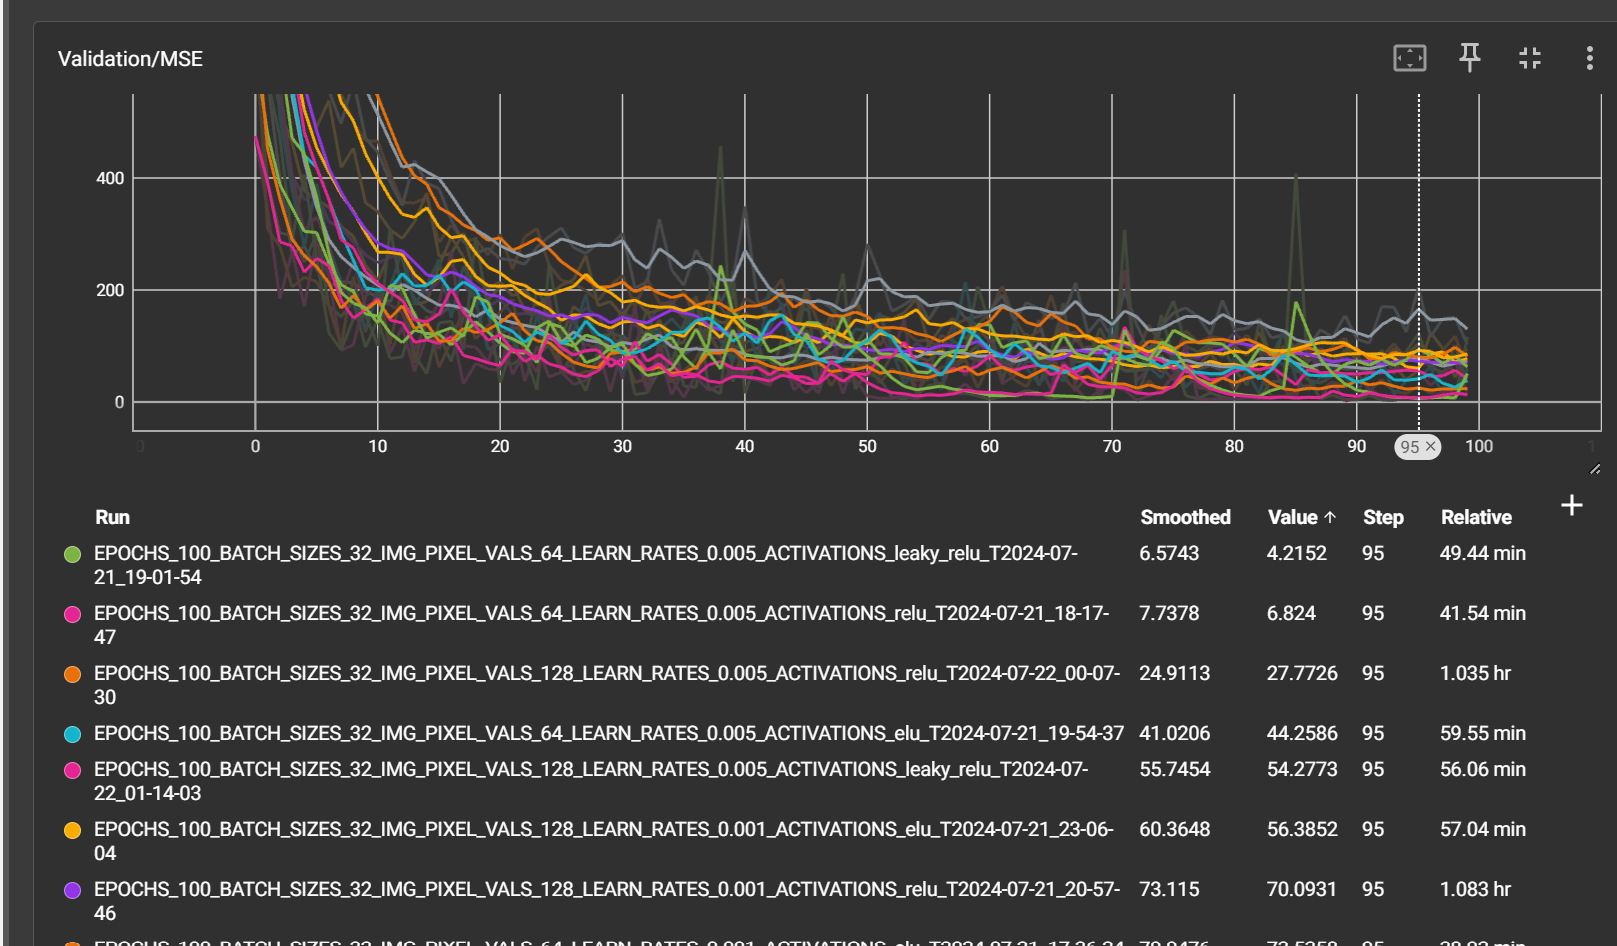

<a name="#literaturverzeichnis"></a>
# 11. Literaturverzeichnis


[1] KIIT AI Mini blitz challenge, Link: https://www.aicrowd.com/challenges/kiit-ai-mini-blitz.

[2] Dissertation Computer Vision-Assisted Surgery: Real-Time Instrument Tracking with Machine Learning Nicola Christin Rieke, Technische Universität München Fakultät für Informatik Lehrstuhl für Informatikanwendungen in der Medizin, Link: https://mediatum.ub.tum.de/doc/1435900/753802.pdf.

[3] Computing Mean & STD in Image Dataset, Link: https://kozodoi.me/blog/20210308/compute-image-stats.

[4] pytorch_image_regession Github Repo, Link: https://github.com/hugohadfield/pytorch_image_regession.

[5] CNN Architecture Boilerplate for image regression, Link: https://github.com/hugohadfield/pytorch_image_regession/blob/main/network.py.

[6] Tensorboard for PyTorch integration, Link: https://www.youtube.com/watch?v=RLqsxWaQdHE.

[7] Pytorch Documentation on Tensorbaord integration, Link: https://pytorch.org/docs/stable/tensorboard.html.

[8] How to Choose an Activation Function for Deep Learning, Link: https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/
